In [1]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster import hierarchy as sch
from scipy.stats import percentileofscore
from yellowbrick.cluster import SilhouetteVisualizer


In [2]:
repeat_customers_df = pd.read_feather("repeat_customers_df.ftr")

with pd.option_context("display.max_columns", None):
    display(repeat_customers_df)


customer_unique_id  total_orders  total_prods_ordered  \
0     4c93744516667ad3b8f1fb645a3116a4             2                    2   
1     1175e95fb47ddff9de6b2b06188f7e0d             2                    2   
2     295c05e81917928d76245e842748184d             2                    2   
3     e9dd12dca17352644a959d9dea133935             2                    2   
4     e079b18794454de9d2be5c12b4392294             2                    6   
...                                ...           ...                  ...   
2796  574e36a816bf7a295404e686062fc0de             2                    3   
2797  76f7d40948174f5cde0fcf8e6147b59d             2                    4   
2798  88fcb680dc8cd2e540010c0750b78242             2                    2   
2799  2dcbfb99d95c7ba6eb992a98627f45b8             2                    3   
2800  da29b8a3970adddb9ed2dc8a492065af             2                    2   

      first_customer_review_score  avg_customer_review_score reordered  \
0                             5.0                        5.0      True   
1                             5.0                        5.0      True   
2                             3.0                        4.0      True   
3                             3.0                        4.0      True   
4                             5.0                        5.0      True   
...                           ...                        ...       ...   
2796                          4.0                        4.5      True   
2797                          2.0                        2.0      True   
2798                          4.0                        4.0      True   
2799                          1.0                        1.0      True   
2800                          4.0                        4.5      True   

     high_first_rating                                          order_ids  \
0                 True  [5741ea1f91b5fbab2bd2dc653a5b5099, 98b737f8bd0...   
1                 True  [7845a2492ab1b4f2cf3d56c7b8da1446, 1ebeea841c5...   
2                False  [cf5e115a19c54f0457aa4c00fb88ae63, 852d2f4d377...   
3                False  [19c0c76962278b152cc44fc63ffd5e48, f916cacb752...   
4                 True  [77b062be7c5bd21712905feb8e1cfeed, 7e3fefb35b0...   
...                ...                                                ...   
2796              True  [25c0762610a416a21571e4ab3cf179b8, 325c8590cc2...   
2797             False  [09d49d145e25e27490765a4085a8e720, b95ee76467f...   
2798              True  [eda613a4e8989dac08362e3326431eaa, 00772b2af35...   
2799             False  [ce5f998d724ed1ac61c890e33b24a33f, 4035b52134b...   
2800              True  [614c5cb06a982f6034ec63bb29030868, 56a69975037...   

                              order_purchase_timestamps  total_spent  \
0     [2017-10-15T12:44:13.000000, 2017-09-14T18:14:...       565.88   
1     [2018-01-18T12:35:45.000000, 2018-01-18T12:35:...        83.19   
2     [2018-06-06T11:59:53.000000, 2018-03-07T15:57:...       281.50   
3     [2018-04-18T09:42:53.000000, 2018-03-05T18:12:...       113.83   
4     [2017-06-14T18:52:29.000000, 2017-06-14T18:31:...       437.78   
...                                                 ...          ...   
2796  [2018-04-26T18:07:40.000000, 2017-06-06T17:00:...       222.86   
2797  [2018-04-29T22:59:41.000000, 2017-12-30T00:06:...       373.60   
2798  [2018-01-19T08:02:06.000000, 2017-04-24T10:53:...       118.61   
2799  [2017-12-03T20:37:09.000000, 2017-11-28T01:16:...       285.23   
2800  [2017-09-18T12:37:24.000000, 2017-06-20T12:40:...       145.42   

      order_delay_days  years_since_last_purchase  months_since_last_purchase  \
0            30.770625                   0.867168                   10.406011   
1             0.000012                   0.607621                    7.291449   
2            90.835174                   0.227907                    2.734889   
3            43.646273                   0.362047                    4.344565   
4          

In [3]:
rfm_df = repeat_customers_df[
    [
        "customer_unique_id",
        "avg_customer_review_score",
        "months_since_last_purchase",
        "orders_per_month",
        "spent_per_month",
    ]
]
rfm_desc = rfm_df.describe()
recency_std = rfm_desc.loc["std", :]["months_since_last_purchase"]
recency_mean = rfm_desc.loc["mean", :]["months_since_last_purchase"]
frequency_std = rfm_desc.loc["std", :]["orders_per_month"]
frequency_mean = rfm_desc.loc["mean", :]["orders_per_month"]
monetary_std = rfm_desc.loc["std", :]["spent_per_month"]
monetary_mean = rfm_desc.loc["mean", :]["spent_per_month"]

print(f"Months since last order STD:\t{recency_std}")
print(f"Months since last order mean:\t{recency_mean}")
print(f"Orders per month STD:\t\t{frequency_std}")
print(f"Orders per month mean:\t\t{frequency_mean}")
print(f"Amount spent per month STD:\t{monetary_std}")
print(f"Amount spent per month mean:\t{monetary_mean}")


Months since last order STD:	4.71035502624664
Months since last order mean:	7.179241860315521
Orders per month STD:		0.5312393777145199
Orders per month mean:		0.34094057102859004
Amount spent per month STD:	157.48305094710398
Amount spent per month mean:	51.86110352550043


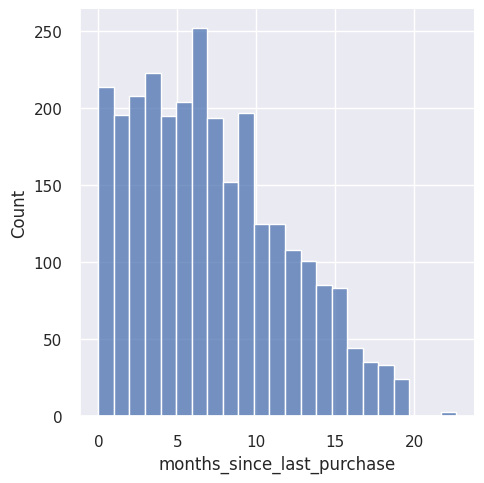

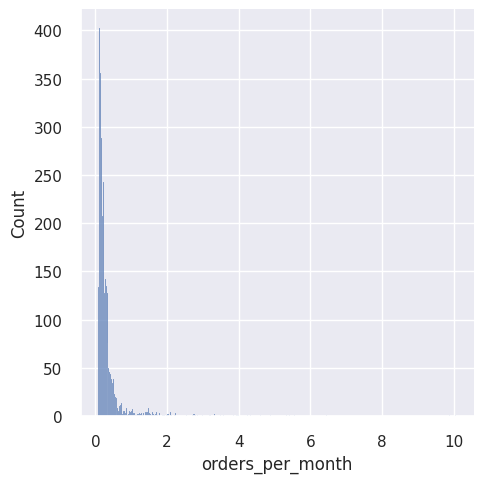

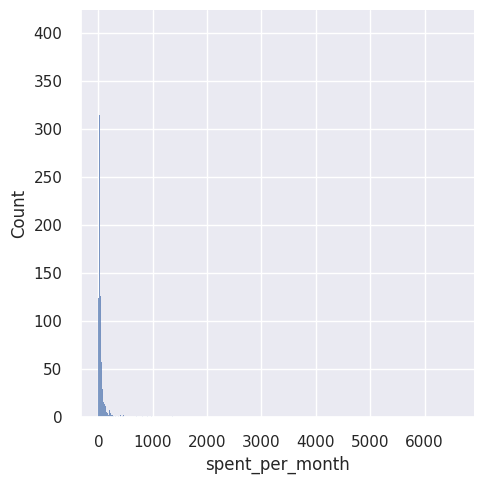

In [4]:
sns.set(style="darkgrid")
sns.displot(rfm_df, x="months_since_last_purchase")
plt.show()
sns.displot(rfm_df, x="orders_per_month")
plt.show()
sns.displot(rfm_df, x="spent_per_month")
plt.show()


Percent dropped by z-score: 2.0


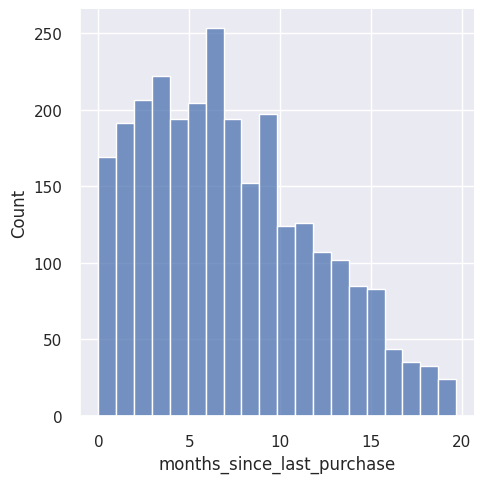

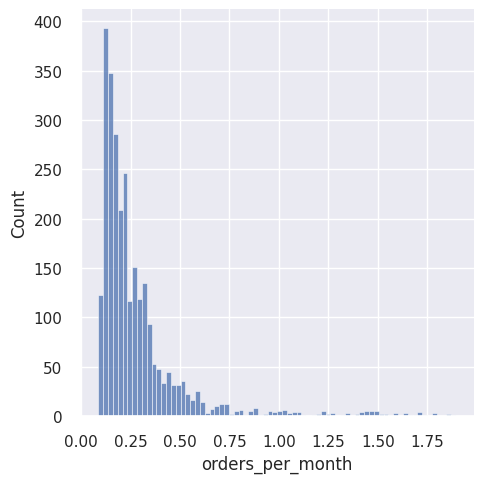

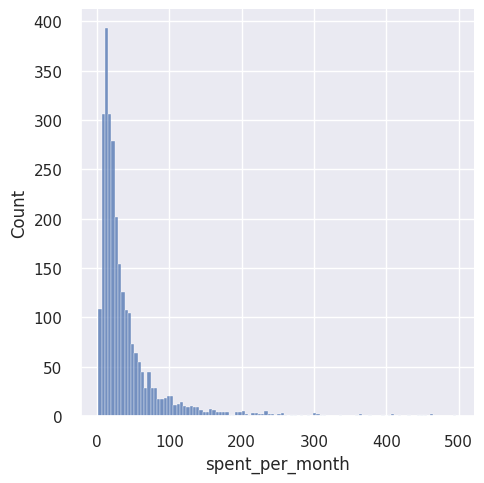

In [5]:
rfm_no_z_outliers_df = (
    rfm_df.drop(
        index=list(
            set(
                rfm_df.loc[
                    (
                        rfm_df["months_since_last_purchase"]
                        < recency_mean - recency_std * 3
                    )
                    | (
                        rfm_df["months_since_last_purchase"]
                        > recency_mean + recency_std * 3
                    )
                ].index.to_list()
                + rfm_df.loc[
                    (rfm_df["orders_per_month"] < frequency_mean - frequency_std * 3)
                    | (rfm_df["orders_per_month"] > frequency_mean + frequency_std * 3)
                ].index.to_list()
                + rfm_df.loc[
                    (rfm_df["spent_per_month"] < monetary_mean - monetary_std * 3)
                    | (rfm_df["spent_per_month"] > monetary_mean + monetary_std * 3)
                ].index.to_list()
            )
        )
    )
    .reset_index()
    .drop("index", axis=1)
)

print(
    f"Percent dropped by z-score: {round((rfm_df.shape[0] - rfm_no_z_outliers_df.shape[0]) / rfm_df.shape[0] * 100, 2)}"
)
sns.set(style="darkgrid")
sns.displot(rfm_no_z_outliers_df, x="months_since_last_purchase")
plt.show()
sns.displot(rfm_no_z_outliers_df, x="orders_per_month")
plt.show()
sns.displot(rfm_no_z_outliers_df, x="spent_per_month")
plt.show()


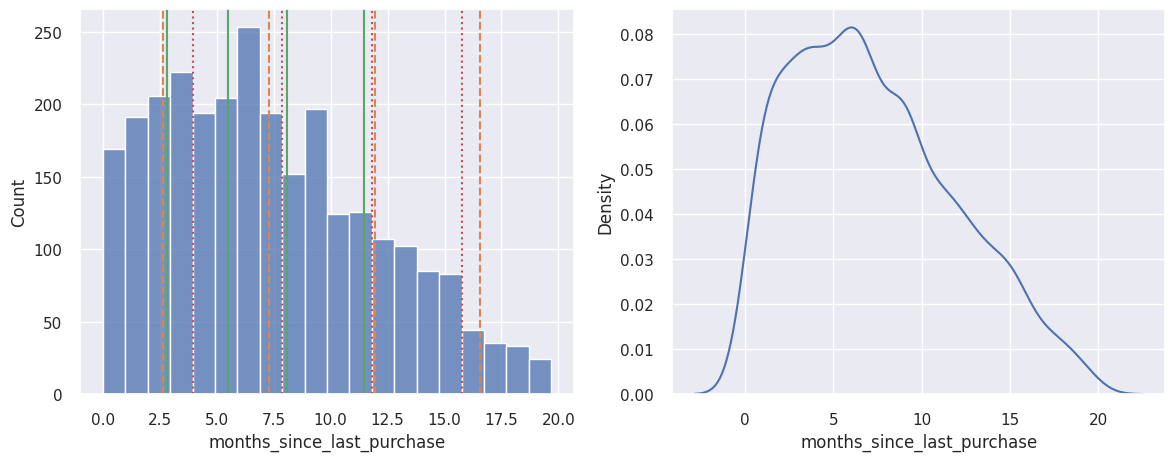

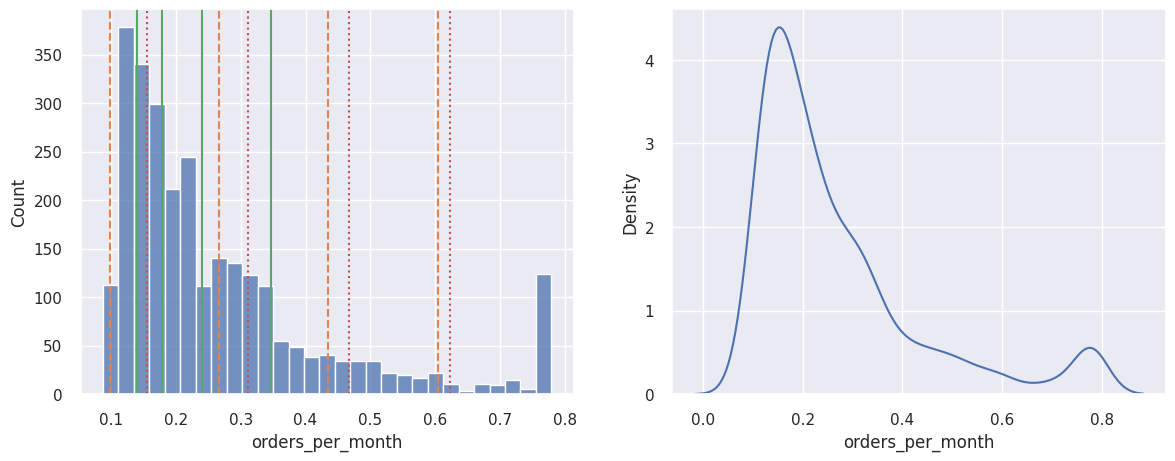

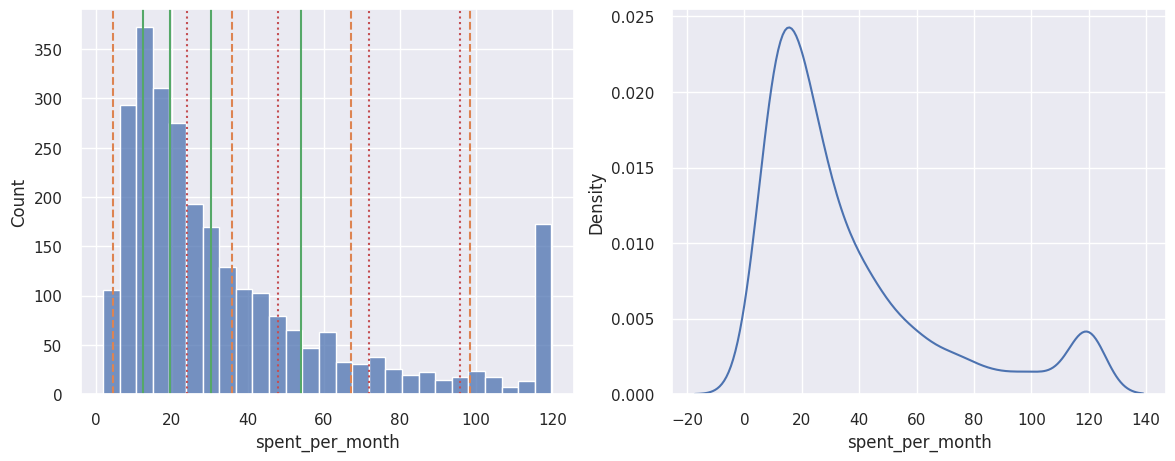

In [6]:
def get_upper_quantile(df, column):
    upper_quantile = 0

    for quantile in [x / 1000 for x in range(500, 1000)]:
        temp_quantile = df[column].quantile(quantile)

        if df.loc[df[column] < temp_quantile][column].skew() > 1.5:
            return upper_quantile

        upper_quantile = temp_quantile


rfm_no_outliers_df = rfm_no_z_outliers_df
upper_quantile_val = get_upper_quantile(rfm_no_outliers_df, "orders_per_month")
rfm_no_outliers_df.loc[
    rfm_no_outliers_df["orders_per_month"] > upper_quantile_val, "orders_per_month"
] = upper_quantile_val
upper_quantile_val = get_upper_quantile(rfm_no_outliers_df, "spent_per_month")
rfm_no_outliers_df.loc[
    rfm_no_outliers_df["spent_per_month"] > upper_quantile_val, "spent_per_month"
] = upper_quantile_val
theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for x in ["months_since_last_purchase", "orders_per_month", "spent_per_month"]:
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs = axs.flatten()
    mean = rfm_no_outliers_df[x].mean()
    std = rfm_no_outliers_df[x].std()

    fig.set_figwidth(14)
    fig.set_figheight(5)
    sns.set(style="darkgrid")
    sns.histplot(rfm_no_outliers_df, x=x, ax=axs[0])
    axs[0].axvline(mean, color=theme_clrs[1], linestyle="--")

    for num_std in [1, 2]:
        axs[0].axvline(mean + std * num_std, color=theme_clrs[1], linestyle="--")
        if num_std < 2:
            axs[0].axvline(
                mean - std * num_std if mean - std * num_std >= 0 else 0,
                color=theme_clrs[1],
                linestyle="--",
            )
    
    for quant in [0.2, 0.4, 0.6, 0.8]:
        axs[0].axvline(rfm_no_outliers_df[x].quantile(quant), color=theme_clrs[2], linestyle="-")
    
    for fifth in [1, 2, 3, 4]:
        axs[0].axvline(rfm_no_outliers_df[x].max() * fifth / 5, color=theme_clrs[3], linestyle=":")

    sns.kdeplot(rfm_no_outliers_df, x=x, ax=axs[1])
    plt.show()


In [7]:
rfm_normalized = rfm_no_outliers_df
col_name_to_metric = {
    "months_since_last_purchase": "recency",
    "orders_per_month": "frequency",
    "spent_per_month": "monetary",
}

for col_name in ["months_since_last_purchase", "orders_per_month", "spent_per_month"]:
    z_scaled = [
        x + 2
        for x in [
            x[0]
            for x in StandardScaler()
            .fit_transform(rfm_normalized[col_name].to_numpy().reshape(-1, 1))
            .tolist()
        ]
    ]

    if col_name == "months_since_last_purchase":
        z_scaled = [x * -1 + 5 for x in z_scaled]

    z_scaled = [5 if x > 5 else x for x in z_scaled]
    rfm_normalized[col_name_to_metric[col_name] + "_z_scaled"] = z_scaled

for col_name in ["months_since_last_purchase", "orders_per_month", "spent_per_month"]:
    quant_scaled = [
        percentileofscore(rfm_normalized[col_name].to_list(), x, kind="weak") / 20
        for x in rfm_normalized[col_name].to_list()
    ]

    if col_name == "months_since_last_purchase":
        quant_scaled = [x * -1 + 5 for x in quant_scaled]

    rfm_normalized[col_name_to_metric[col_name] + "_quant_scaled"] = quant_scaled

for col_name in ["months_since_last_purchase", "orders_per_month", "spent_per_month"]:
    min_max_scaled = [
        x * 5
        for x in [
            x[0]
            for x in MinMaxScaler()
            .fit_transform(rfm_normalized[col_name].to_numpy().reshape(-1, 1))
            .tolist()
        ]
    ]

    if col_name == "months_since_last_purchase":
        min_max_scaled = [x * -1 + 5 for x in min_max_scaled]

    rfm_normalized[col_name_to_metric[col_name] + "_min_max_scaled"] = min_max_scaled

display(rfm_normalized)


customer_unique_id  avg_customer_review_score  \
0     4c93744516667ad3b8f1fb645a3116a4                        5.0   
1     1175e95fb47ddff9de6b2b06188f7e0d                        5.0   
2     295c05e81917928d76245e842748184d                        4.0   
3     e9dd12dca17352644a959d9dea133935                        4.0   
4     e079b18794454de9d2be5c12b4392294                        5.0   
...                                ...                        ...   
2740  574e36a816bf7a295404e686062fc0de                        4.5   
2741  76f7d40948174f5cde0fcf8e6147b59d                        2.0   
2742  88fcb680dc8cd2e540010c0750b78242                        4.0   
2743  2dcbfb99d95c7ba6eb992a98627f45b8                        1.0   
2744  da29b8a3970adddb9ed2dc8a492065af                        4.5   

      months_since_last_purchase  orders_per_month  spent_per_month  \
0                      10.406011          0.174851        49.472289   
1                       7.291449          0.273732        11.385874   
2                       2.734889          0.349356        49.171831   
3                       4.344565          0.345575        19.668419   
4                      14.430412          0.138308        30.274167   
...                          ...               ...              ...   
2740                    4.070777          0.135819        15.134356   
2741                    3.965768          0.251644        47.007064   
2742                    7.264893          0.123866         7.345845   
2743                    8.788685          0.222284        31.701082   
2744                   11.291412          0.140140        10.189609   

      recency_z_scaled  frequency_z_scaled  monetary_z_scaled  \
0             2.328123            1.454149           2.436852   
1             2.999351            2.041552           1.216010   
2             3.981349            2.490797           2.427221   
3             3.634443            2.468339           1.481503   
4             1.460812            1.237065           1.821465   
...                ...                 ...                ...   
2740          3.693448            1.222283           1.336166   
2741          3.716079            1.910338           2.357830   
2742          3.005075            1.151271           1.086509   
2743          2.676678            1.735928           1.867204   
2744          2.137307            1.247952           1.177664   

      recency_quant_scaled  frequency_quant_scaled  monetary_quant_scaled  \
0                 1.255009                1.901639               3.879781   
1                 2.238616                3.306011               0.821494   
2                 4.049180                4.010929               3.865209   
3                 3.418944                3.985428               2.001821   
4                 0.466302                0.978142               3.000000   
...                    ...                     ...                    ...   
2740              3.513661                0.908925               1.428051   
2741              3.553734                3.074681               3.806922   
2742              2.247723                0.526412               0.295082   
2743              1.774135                2.741348               3.081967   
2744              1.060109                1.030965               0.657559   

      recency_min_max_scaled  frequency_min_max_scaled  \
0                   2.356975                  0.629732   
1                   3.148043                  1.345087   
2                   4.305365                  1.892189   
3                   3.896523                  1.864839   
4                   1.334816                  0.365361   
...                      ...                       ...   
2740                3.966062                  0.347359   
2741                3.992734                  1.185291   
2742                3.154788                  0.260879   
2743                2.767760                  0.9728

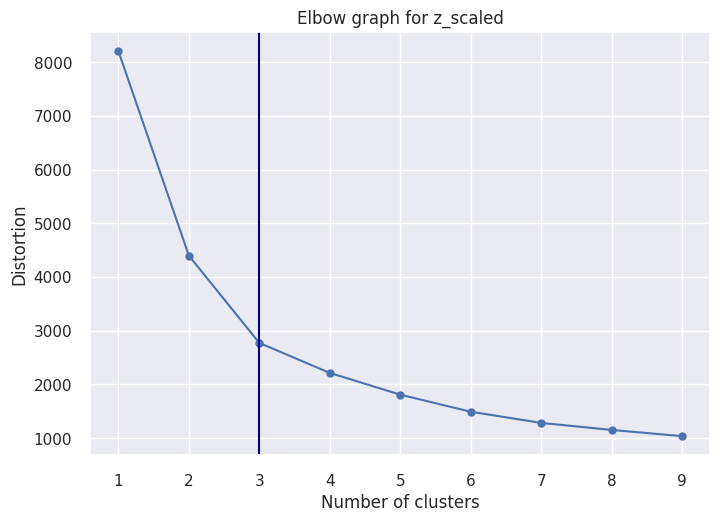

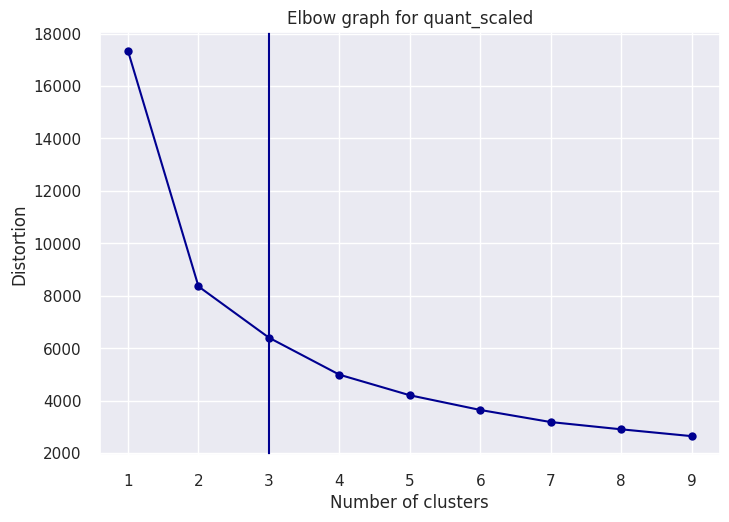

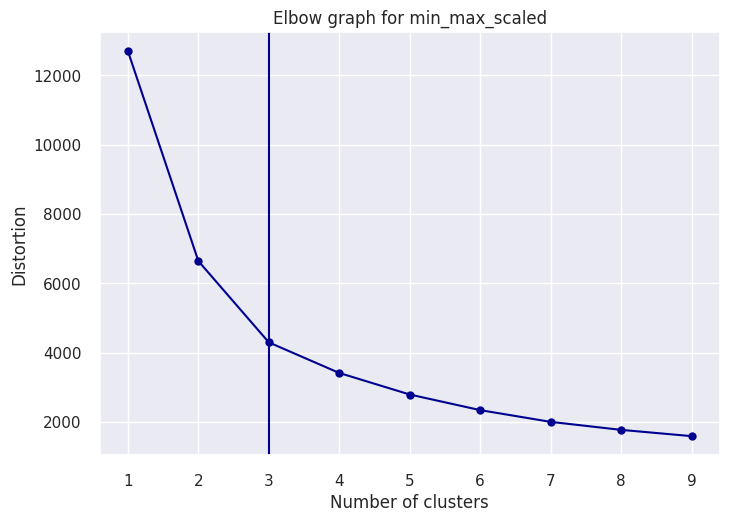

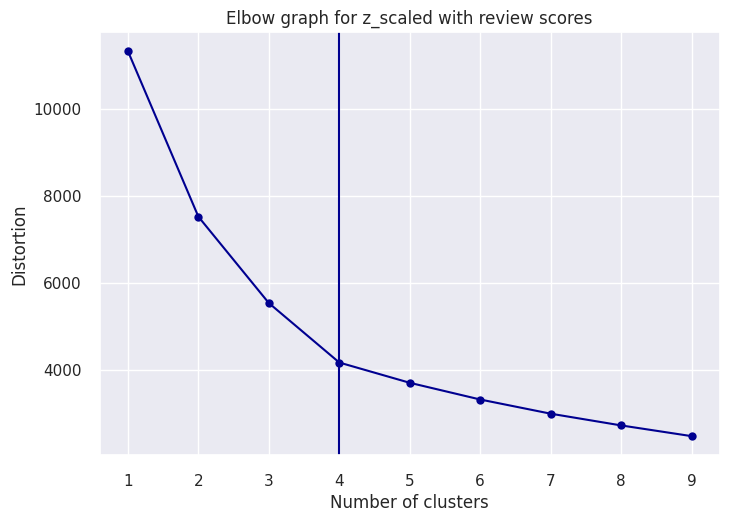

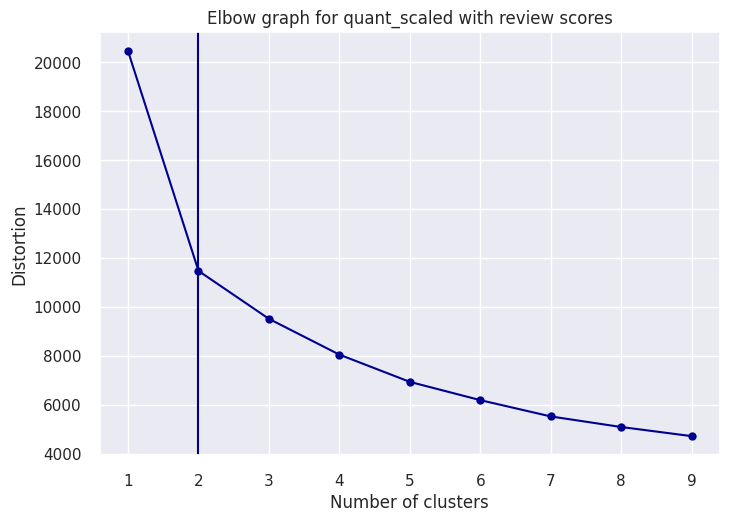

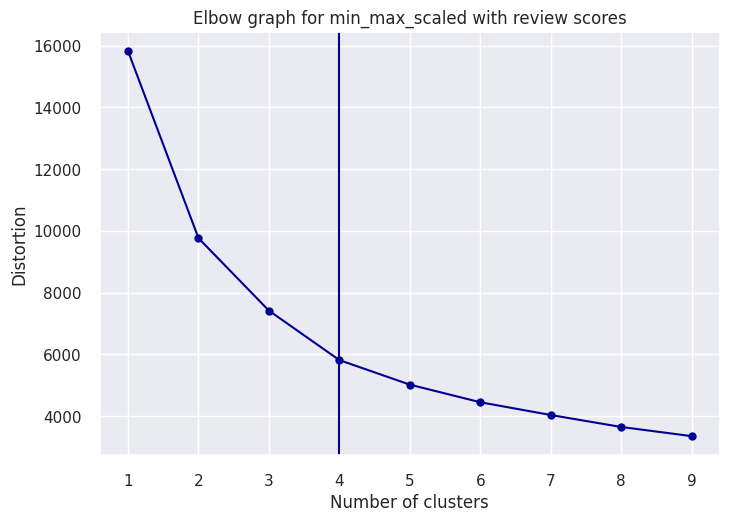

In [8]:
num_clusters = {}

for has_review_score in [False, True]:
    for scaling_type in ["z_scaled", "quant_scaled", "min_max_scaled"]:
        distortions = []

        for i in range(1, 10):
            k_means_model = KMeans(n_clusters=i, n_init=10, random_state=0)

            k_means_model.fit(
                rfm_normalized[
                    [
                        "recency_" + scaling_type,
                        "frequency_" + scaling_type,
                        "monetary_" + scaling_type,
                    ]
                    + (["avg_customer_review_score"] if has_review_score else [])
                ].fillna(
                    rfm_normalized["avg_customer_review_score"].mean()
                    if has_review_score
                    else 0
                )
            )
            distortions.append(k_means_model.inertia_)

        num_clusters[
            scaling_type + ("_with_review_scores" if has_review_score else "")
        ] = KneeLocator(
            range(1, 10), distortions, curve="convex", direction="decreasing"
        ).elbow
        # num_clusters[scaling_type] = KneeLocator(
        #     range(1, 10), distortions, curve="convex", direction="decreasing"
        # ).elbow + 1

        plt.plot(range(1, 10), distortions, marker="o")
        plt.xlabel("Number of clusters")
        plt.ylabel("Distortion")
        plt.title(
            "Elbow graph for "
            + scaling_type
            + (" with review scores" if has_review_score else "")
        )
        plt.axvline(
            num_clusters[
                scaling_type + ("_with_review_scores" if has_review_score else "")
            ]
        )
        sns.set_style("darkgrid")
        sns.set_palette("gnuplot2")
        plt.show()


z_scaled


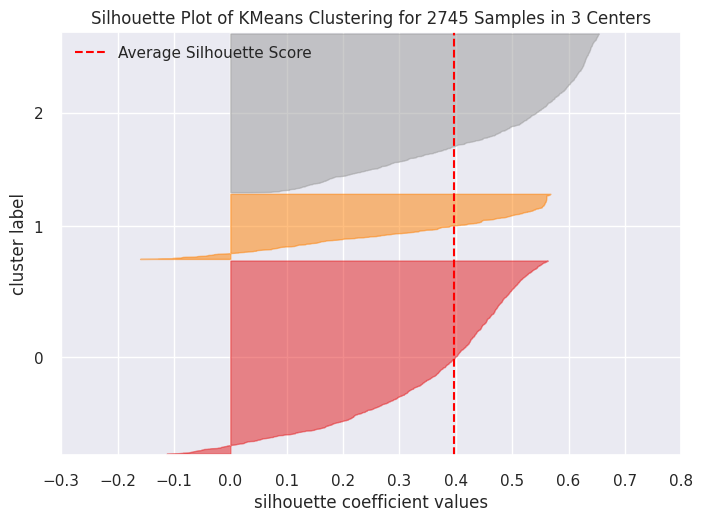

quant_scaled


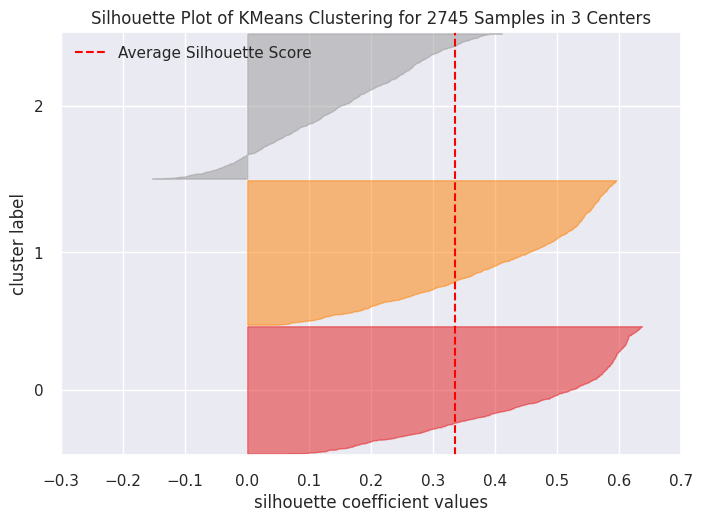

min_max_scaled


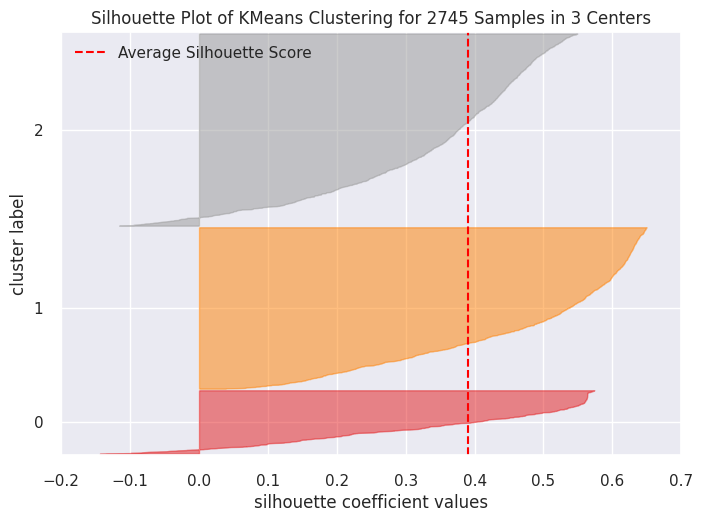

z_scaled with review scores


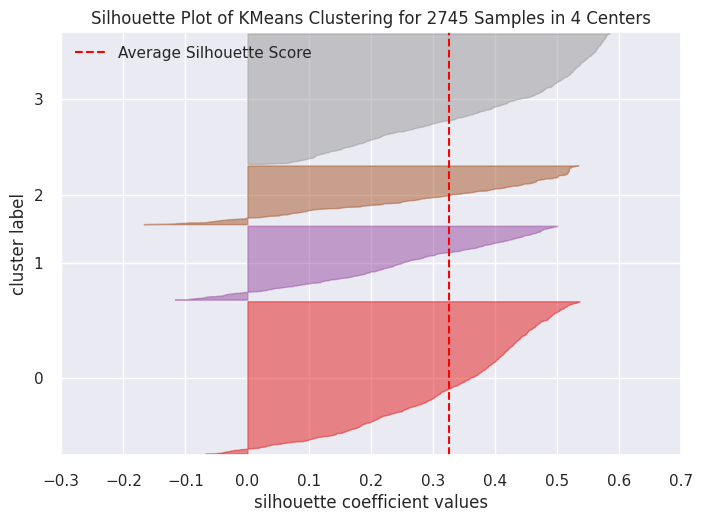

quant_scaled with review scores


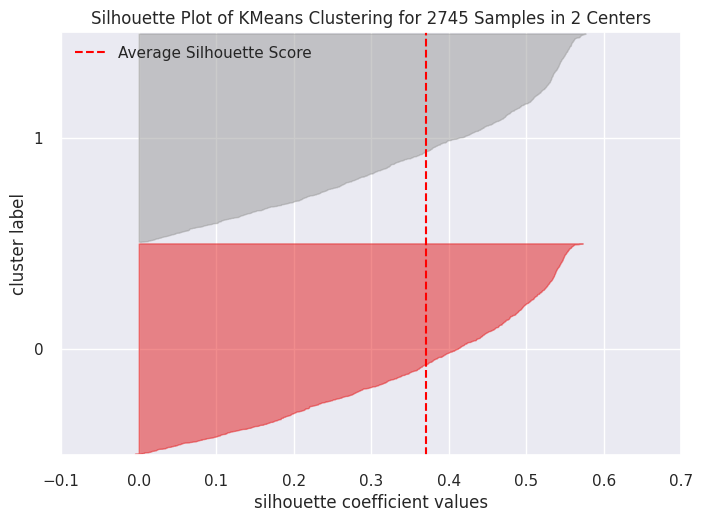

min_max_scaled with review scores


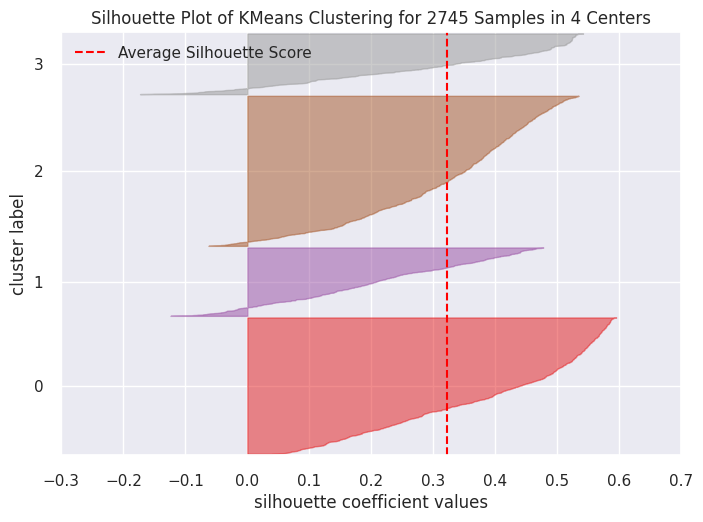

In [9]:
for has_review_score in [False, True]:
    for scaling_type in ["z_scaled", "quant_scaled", "min_max_scaled"]:
        sil_vis = SilhouetteVisualizer(
            KMeans(
                n_clusters=num_clusters[
                    scaling_type + ("_with_review_scores" if has_review_score else "")
                ],
                n_init=10,
                random_state=0,
            )
        )

        sil_vis.fit(
            rfm_normalized[
                [
                    "recency_" + scaling_type,
                    "frequency_" + scaling_type,
                    "monetary_" + scaling_type,
                ]
                + (["avg_customer_review_score"] if has_review_score else [])
            ].fillna(
                rfm_normalized["avg_customer_review_score"].mean()
                if has_review_score
                else 0
            )
        )
        print(scaling_type + (" with review scores" if has_review_score else ""))
        sns.set_style("darkgrid")
        sil_vis.show()


In [10]:
rfm_with_cluster_kmeans = rfm_normalized.copy()
rfm_rating_with_cluster_kmeans = rfm_normalized.copy()

for scaling_type in ["z_scaled", "quant_scaled", "min_max_scaled"]:
    rfm_with_cluster_kmeans[scaling_type + "_cluster_kmeans"] = KMeans(
        n_clusters=num_clusters[scaling_type], n_init=10, random_state=0
    ).fit_predict(
        rfm_with_cluster_kmeans[
            [
                "recency_" + scaling_type,
                "frequency_" + scaling_type,
                "monetary_" + scaling_type,
            ]
        ]
    )
for scaling_type in ["z_scaled", "quant_scaled", "min_max_scaled"]:
    rfm_rating_with_cluster_kmeans[scaling_type + "_cluster_kmeans"] = KMeans(
        n_clusters=num_clusters[scaling_type + "_with_review_scores"],
        n_init=10,
        random_state=0,
    ).fit_predict(
        rfm_rating_with_cluster_kmeans[
            [
                "recency_" + scaling_type,
                "frequency_" + scaling_type,
                "monetary_" + scaling_type,
                "avg_customer_review_score",
            ]
        ].fillna(rfm_normalized["avg_customer_review_score"].mean())
    )

display(rfm_with_cluster_kmeans)
display(rfm_rating_with_cluster_kmeans)


customer_unique_id  avg_customer_review_score  \
0     4c93744516667ad3b8f1fb645a3116a4                        5.0   
1     1175e95fb47ddff9de6b2b06188f7e0d                        5.0   
2     295c05e81917928d76245e842748184d                        4.0   
3     e9dd12dca17352644a959d9dea133935                        4.0   
4     e079b18794454de9d2be5c12b4392294                        5.0   
...                                ...                        ...   
2740  574e36a816bf7a295404e686062fc0de                        4.5   
2741  76f7d40948174f5cde0fcf8e6147b59d                        2.0   
2742  88fcb680dc8cd2e540010c0750b78242                        4.0   
2743  2dcbfb99d95c7ba6eb992a98627f45b8                        1.0   
2744  da29b8a3970adddb9ed2dc8a492065af                        4.5   

      months_since_last_purchase  orders_per_month  spent_per_month  \
0                      10.406011          0.174851        49.472289   
1                       7.291449          0.273732        11.385874   
2                       2.734889          0.349356        49.171831   
3                       4.344565          0.345575        19.668419   
4                      14.430412          0.138308        30.274167   
...                          ...               ...              ...   
2740                    4.070777          0.135819        15.134356   
2741                    3.965768          0.251644        47.007064   
2742                    7.264893          0.123866         7.345845   
2743                    8.788685          0.222284        31.701082   
2744                   11.291412          0.140140        10.189609   

      recency_z_scaled  frequency_z_scaled  monetary_z_scaled  \
0             2.328123            1.454149           2.436852   
1             2.999351            2.041552           1.216010   
2             3.981349            2.490797           2.427221   
3             3.634443            2.468339           1.481503   
4             1.460812            1.237065           1.821465   
...                ...                 ...                ...   
2740          3.693448            1.222283           1.336166   
2741          3.716079            1.910338           2.357830   
2742          3.005075            1.151271           1.086509   
2743          2.676678            1.735928           1.867204   
2744          2.137307            1.247952           1.177664   

      recency_quant_scaled  frequency_quant_scaled  monetary_quant_scaled  \
0                 1.255009                1.901639               3.879781   
1                 2.238616                3.306011               0.821494   
2                 4.049180                4.010929               3.865209   
3                 3.418944                3.985428               2.001821   
4                 0.466302                0.978142               3.000000   
...                    ...                     ...                    ...   
2740              3.513661                0.908925               1.428051   
2741              3.553734                3.074681               3.806922   
2742              2.247723                0.526412               0.295082   
2743              1.774135                2.741348               3.081967   
2744              1.060109                1.030965               0.657559   

      recency_min_max_scaled  frequency_min_max_scaled  \
0                   2.356975                  0.629732   
1                   3.148043                  1.345087   
2                   4.305365                  1.892189   
3                   3.896523                  1.864839   
4                   1.334816                  0.365361   
...                      ...                       ...   
2740                3.966062                  0.347359   
2741                3.992734                  1.185291   
2742                3.154788                  0.260879   
2743                2.767760                  0.9728

customer_unique_id  avg_customer_review_score  \
0     4c93744516667ad3b8f1fb645a3116a4                        5.0   
1     1175e95fb47ddff9de6b2b06188f7e0d                        5.0   
2     295c05e81917928d76245e842748184d                        4.0   
3     e9dd12dca17352644a959d9dea133935                        4.0   
4     e079b18794454de9d2be5c12b4392294                        5.0   
...                                ...                        ...   
2740  574e36a816bf7a295404e686062fc0de                        4.5   
2741  76f7d40948174f5cde0fcf8e6147b59d                        2.0   
2742  88fcb680dc8cd2e540010c0750b78242                        4.0   
2743  2dcbfb99d95c7ba6eb992a98627f45b8                        1.0   
2744  da29b8a3970adddb9ed2dc8a492065af                        4.5   

      months_since_last_purchase  orders_per_month  spent_per_month  \
0                      10.406011          0.174851        49.472289   
1                       7.291449          0.273732        11.385874   
2                       2.734889          0.349356        49.171831   
3                       4.344565          0.345575        19.668419   
4                      14.430412          0.138308        30.274167   
...                          ...               ...              ...   
2740                    4.070777          0.135819        15.134356   
2741                    3.965768          0.251644        47.007064   
2742                    7.264893          0.123866         7.345845   
2743                    8.788685          0.222284        31.701082   
2744                   11.291412          0.140140        10.189609   

      recency_z_scaled  frequency_z_scaled  monetary_z_scaled  \
0             2.328123            1.454149           2.436852   
1             2.999351            2.041552           1.216010   
2             3.981349            2.490797           2.427221   
3             3.634443            2.468339           1.481503   
4             1.460812            1.237065           1.821465   
...                ...                 ...                ...   
2740          3.693448            1.222283           1.336166   
2741          3.716079            1.910338           2.357830   
2742          3.005075            1.151271           1.086509   
2743          2.676678            1.735928           1.867204   
2744          2.137307            1.247952           1.177664   

      recency_quant_scaled  frequency_quant_scaled  monetary_quant_scaled  \
0                 1.255009                1.901639               3.879781   
1                 2.238616                3.306011               0.821494   
2                 4.049180                4.010929               3.865209   
3                 3.418944                3.985428               2.001821   
4                 0.466302                0.978142               3.000000   
...                    ...                     ...                    ...   
2740              3.513661                0.908925               1.428051   
2741              3.553734                3.074681               3.806922   
2742              2.247723                0.526412               0.295082   
2743              1.774135                2.741348               3.081967   
2744              1.060109                1.030965               0.657559   

      recency_min_max_scaled  frequency_min_max_scaled  \
0                   2.356975                  0.629732   
1                   3.148043                  1.345087   
2                   4.305365                  1.892189   
3                   3.896523                  1.864839   
4                   1.334816                  0.365361   
...                      ...                       ...   
2740                3.966062                  0.347359   
2741                3.992734                  1.185291   
2742                3.154788                  0.260879   
2743                2.767760                  0.9728

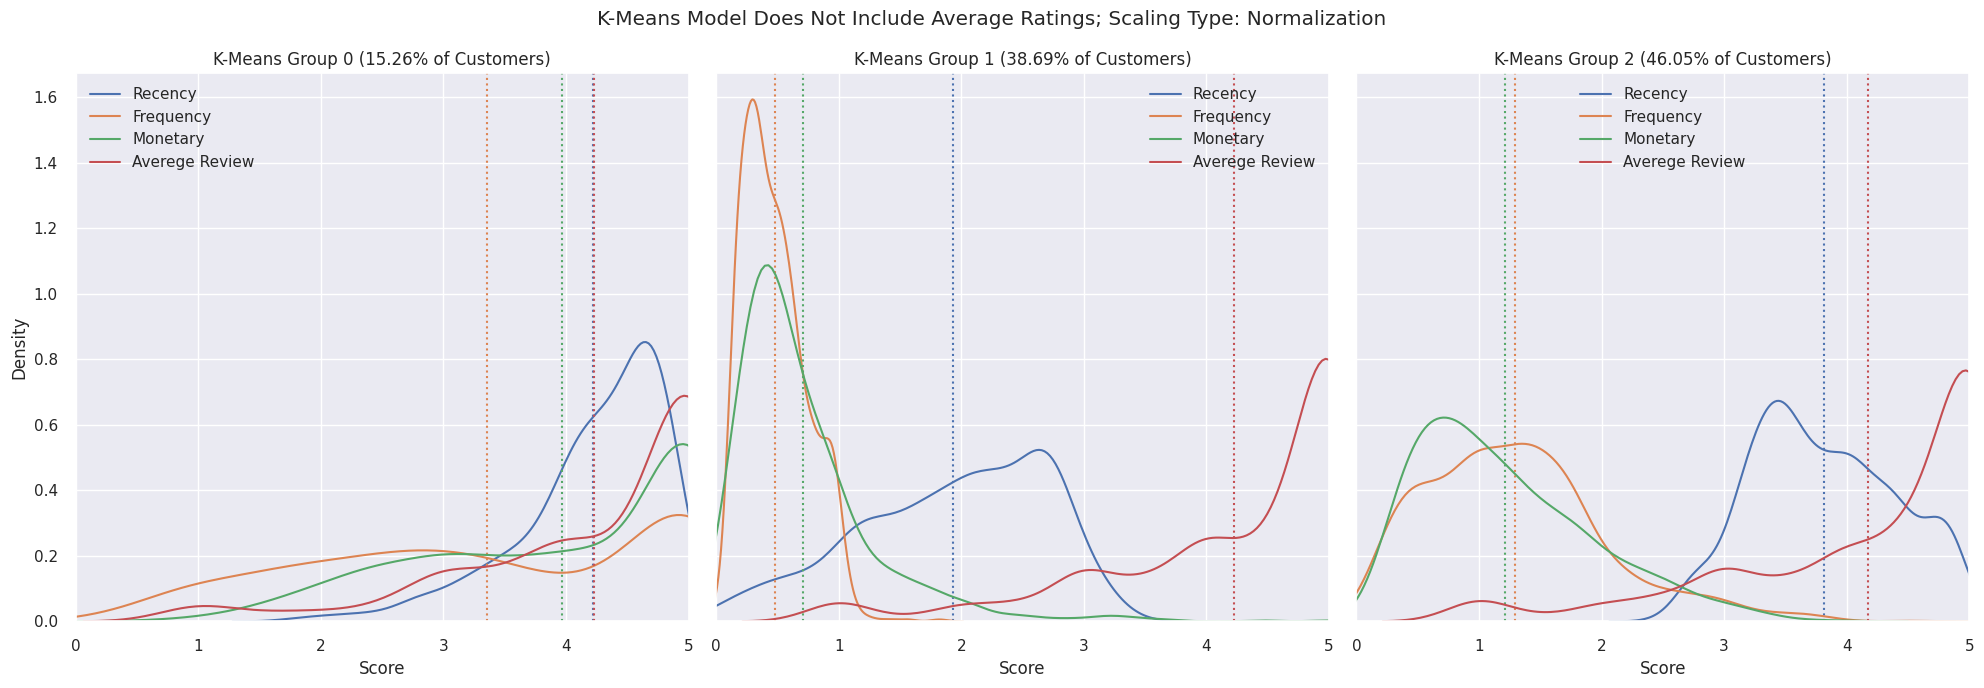

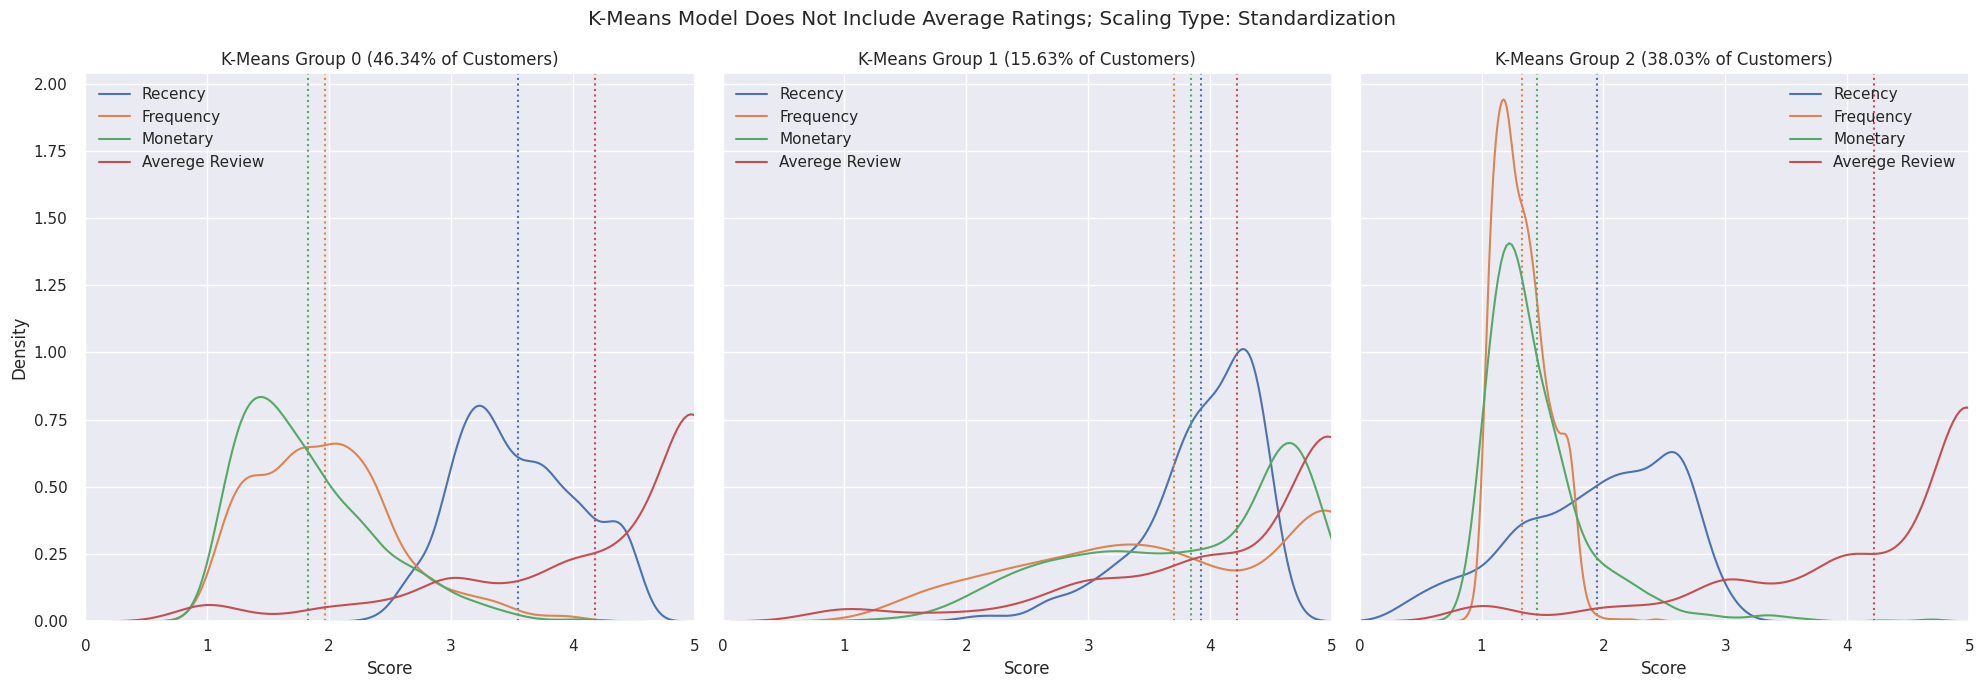

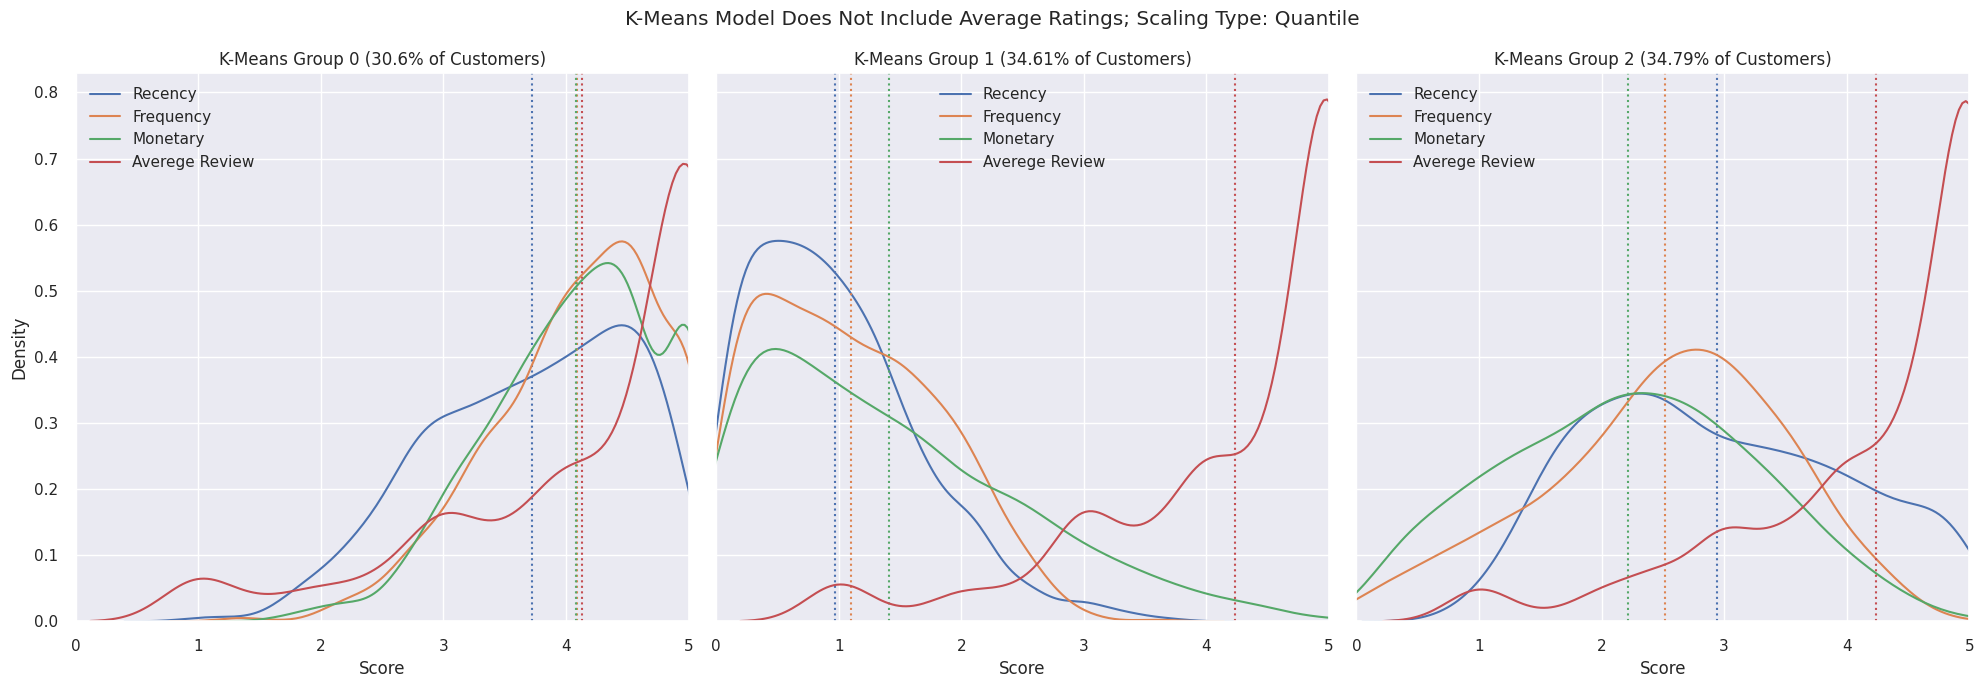

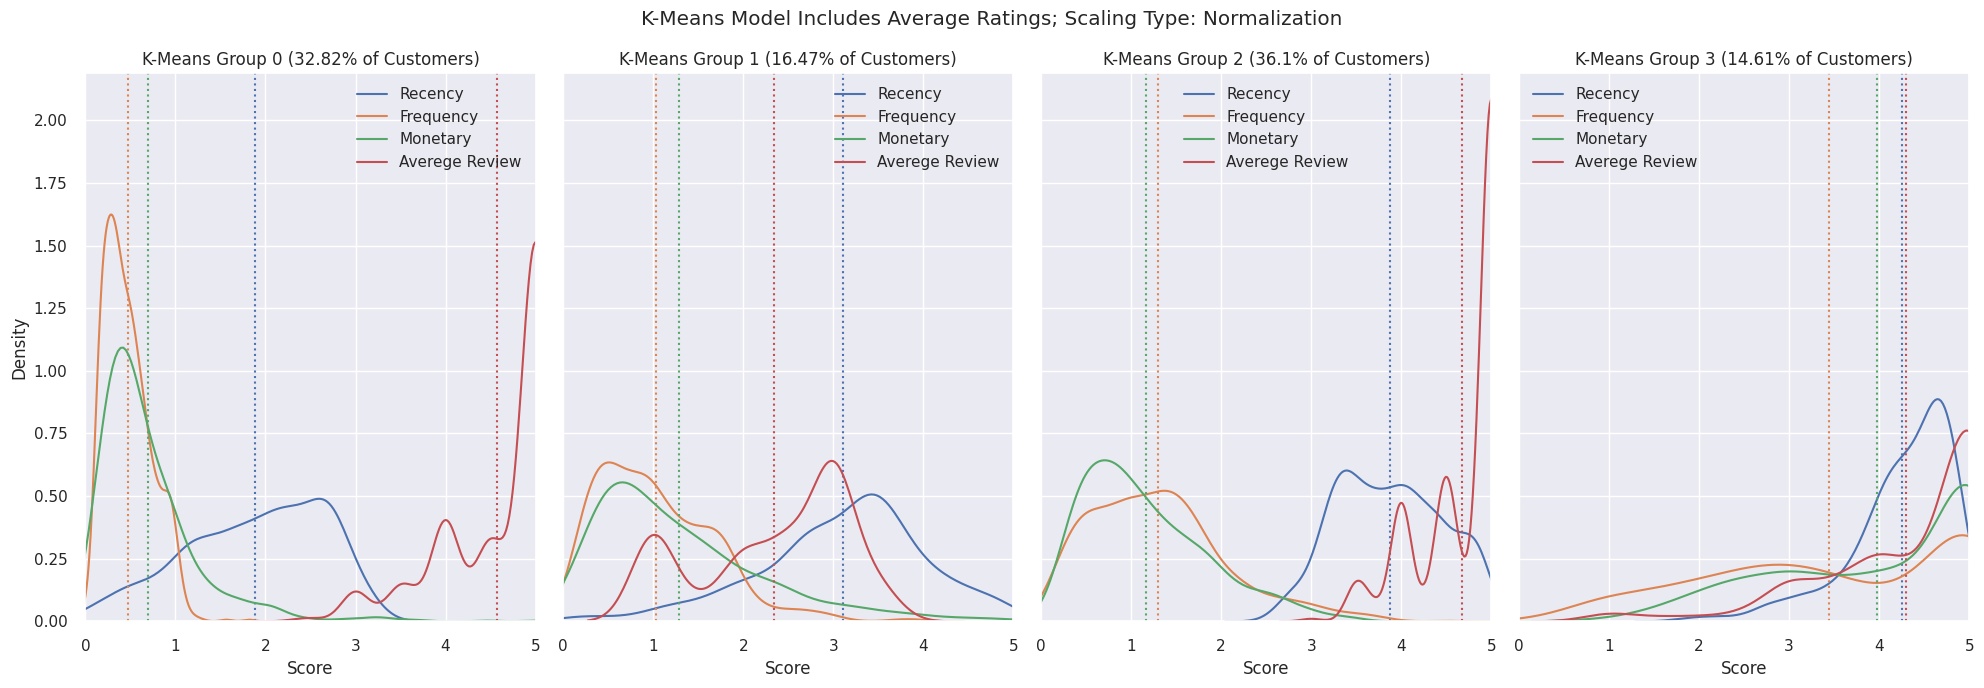

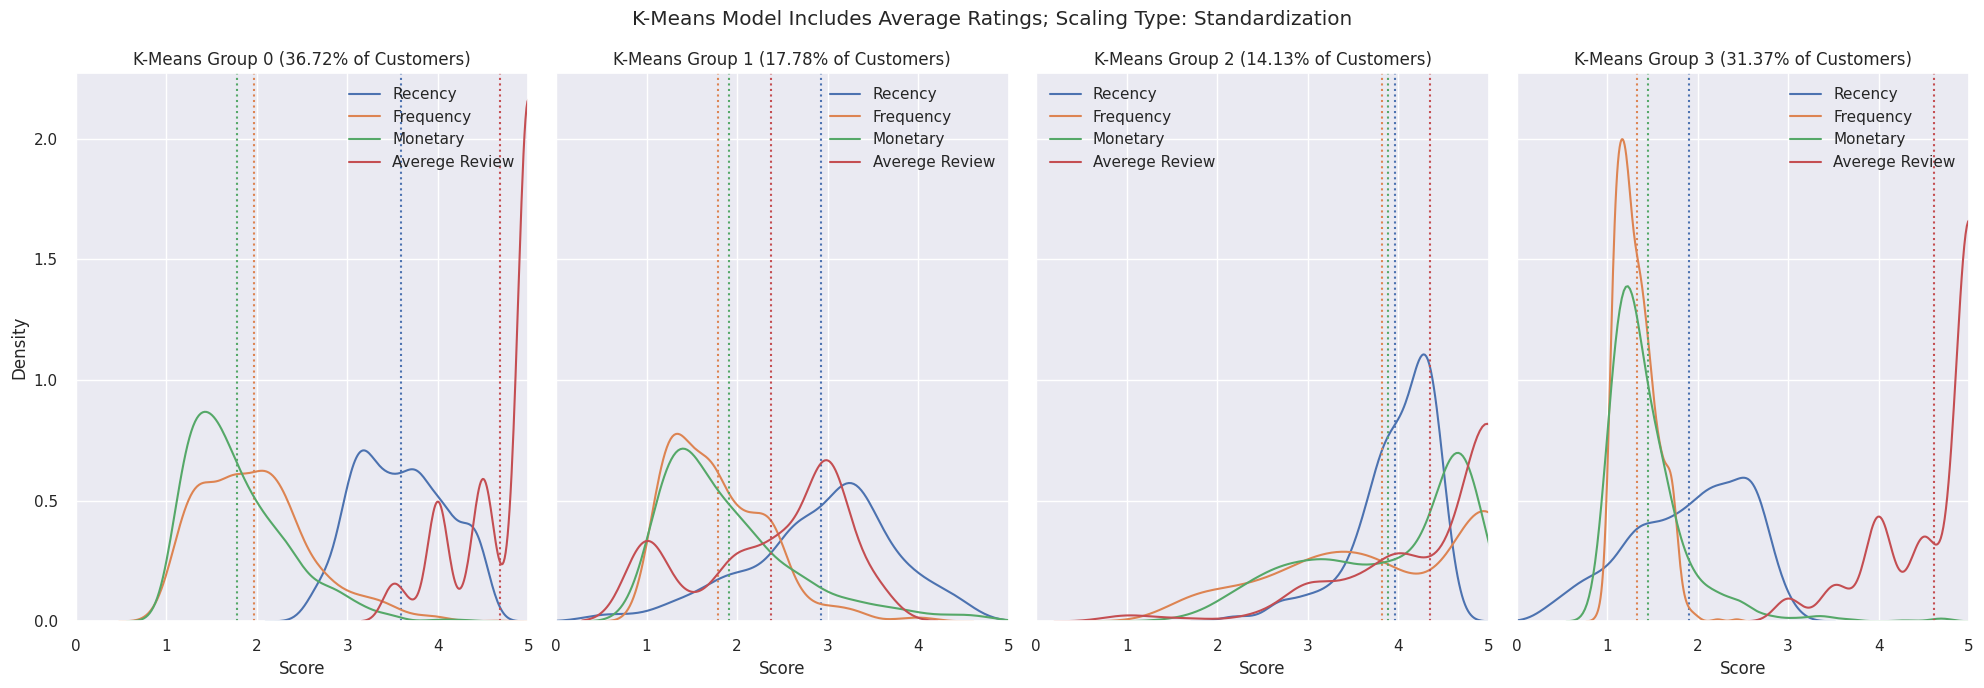

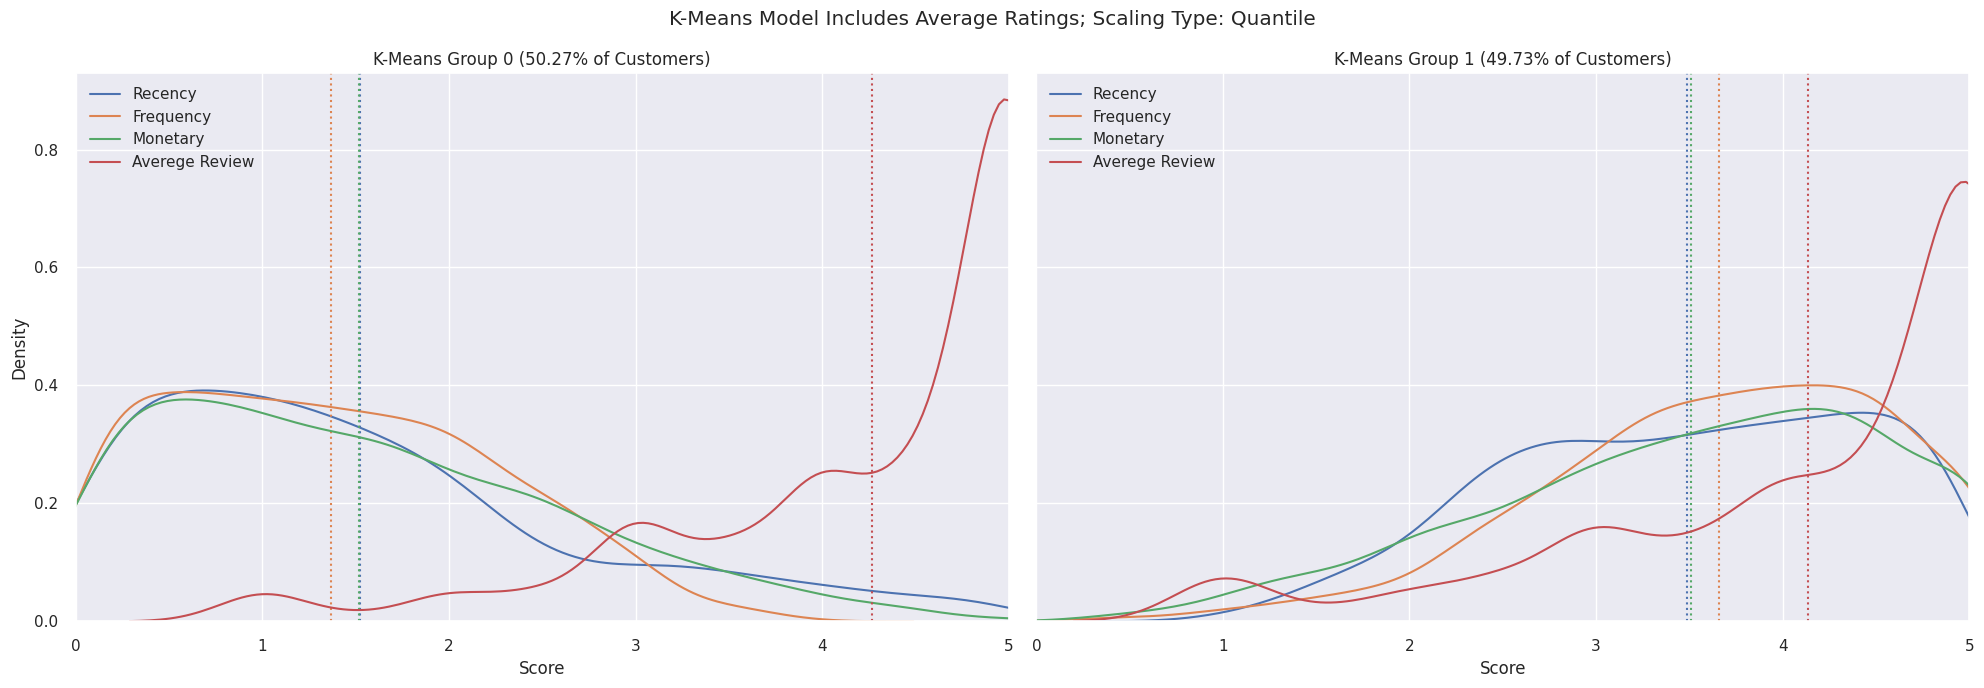

In [11]:
for df, incl_avg_str in [
    [rfm_with_cluster_kmeans, "K-Means Model Does Not Include Average Ratings; "],
    [rfm_rating_with_cluster_kmeans, "K-Means Model Includes Average Ratings; "],
]:
    for scaling_type in ["min_max_scaled", "z_scaled", "quant_scaled"]:
        ax_idx = 0
        fig, axs = plt.subplots(
            nrows=1,
            ncols=len(df[scaling_type + "_cluster_kmeans"].unique().tolist()),
            sharey=True,
        )
        axs = axs.flatten()

        fig.set_figwidth(20)
        fig.set_figheight(7)

        for group_label in sorted(
            df[scaling_type + "_cluster_kmeans"].unique().tolist()
        ):
            group_df = df.loc[df[scaling_type + "_cluster_kmeans"] == group_label]

            sns.set(style="darkgrid")
            sns.kdeplot(
                data=group_df,
                x="recency_" + scaling_type,
                color=theme_clrs[0],
                label="Recency",
                ax=axs[ax_idx],
            )
            axs[ax_idx].axvline(
                group_df["recency_" + scaling_type].mean(),
                color=theme_clrs[0],
                linestyle=":",
            )
            sns.kdeplot(
                data=group_df,
                x="frequency_" + scaling_type,
                color=theme_clrs[1],
                label="Frequency",
                ax=axs[ax_idx],
            )
            axs[ax_idx].axvline(
                group_df["frequency_" + scaling_type].mean(),
                color=theme_clrs[1],
                linestyle=":",
            )
            sns.kdeplot(
                data=group_df,
                x="monetary_" + scaling_type,
                color=theme_clrs[2],
                label="Monetary",
                ax=axs[ax_idx],
            )
            axs[ax_idx].axvline(
                group_df["monetary_" + scaling_type].mean(),
                color=theme_clrs[2],
                linestyle=":",
            )
            sns.kdeplot(
                data=group_df,
                x="avg_customer_review_score",
                color=theme_clrs[3],
                label="Averege Review",
                ax=axs[ax_idx],
            )
            axs[ax_idx].axvline(
                group_df["avg_customer_review_score"].mean(),
                color=theme_clrs[3],
                linestyle=":",
            )
            axs[ax_idx].set_xlim(left=0, right=5)
            axs[ax_idx].set_xlabel("Score")
            axs[ax_idx].set_title(
                "K-Means Group "
                + str(group_label)
                + f" ({round(group_df.shape[0] / df.shape[0] * 100, 2)}% of Customers)"
            )

            axs[ax_idx].legend()

            ax_idx += 1

        plt.suptitle(
            incl_avg_str
            + "Scaling Type: "
            + (
                "Standardization"
                if scaling_type == "z_scaled"
                else "Normalization"
                if scaling_type == "min_max_scaled"
                else "Quantile"
            )
        )
        plt.tight_layout()
        plt.show()


In [12]:
for df, incl_avg_str in [
    [rfm_with_cluster_kmeans, "K-Means Model Does Not Include Average Ratings; "],
    [rfm_rating_with_cluster_kmeans, "K-Means Model Includes Average Ratings; "],
]:
    for scaling_type in ["min_max_scaled", "z_scaled", "quant_scaled"]:
        fig = px.scatter_3d(
            df,
            x="recency_" + scaling_type,
            y="frequency_" + scaling_type,
            z="monetary_" + scaling_type,
            labels={
                "recency_" + scaling_type: "Recency",
                "frequency_" + scaling_type: "Frequency",
                "monetary_" + scaling_type: "Monetary",
                scaling_type + "_cluster_kmeans": "K-Means Group",
            },
            color=scaling_type + "_cluster_kmeans",
            opacity=0.5,
        )

        fig.update_traces(marker_size=3)
        fig.layout.title = (
            incl_avg_str
            + "Scaling Type: "
            + (
                "Standardization"
                if scaling_type == "z_scaled"
                else "Normalization"
                if scaling_type == "min_max_scaled"
                else "Quantile"
            )
        )
        fig.show()


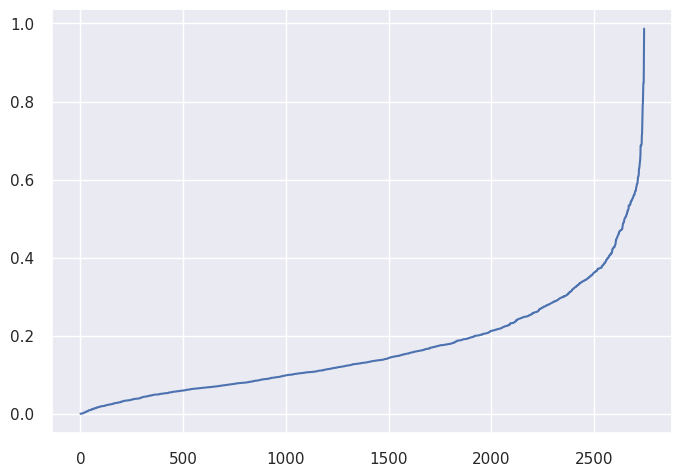

In [13]:
X_feats = [
    "recency_z_scaled",
    "frequency_z_scaled",
    "monetary_z_scaled",
    "avg_customer_review_score",
]
rfm_with_dbscan_group = rfm_normalized.copy()[X_feats].fillna(
    rfm_normalized["avg_customer_review_score"].mean()
)
distances, indices = (
    NearestNeighbors(n_neighbors=2)
    .fit(rfm_with_dbscan_group)
    .kneighbors(rfm_with_dbscan_group)
)
distances = np.sort(distances, axis=0)[:, 1]

plt.plot(distances)
plt.show()


In [14]:
for min_samples in [5, 10, 15, 20, 25, 30]:
    rfm_with_dbscan_group["dbscan_group"] = DBSCAN(
        eps=0.36, min_samples=min_samples
    ).fit_predict(rfm_with_dbscan_group[X_feats])
    rfm_with_dbscan_group_wo_outliers = rfm_with_dbscan_group.loc[
        rfm_with_dbscan_group["dbscan_group"] != -1
    ]
    silh_score = silhouette_score(
        rfm_with_dbscan_group_wo_outliers[X_feats],
        rfm_with_dbscan_group_wo_outliers["dbscan_group"],
    )

    print(f"minPts: {min_samples}")
    print(
        f"Number of clusters: {len(rfm_with_dbscan_group_wo_outliers['dbscan_group'].unique())}"
    )
    print(
        f"Completeness: {rfm_with_dbscan_group_wo_outliers.shape[0] / rfm_with_dbscan_group.shape[0]}"
    )
    print(f"Silhouette Score: {silh_score}")


minPts: 5
Number of clusters: 25
Completeness: 0.7996357012750456
Silhouette Score: -0.19899808583667558
minPts: 10
Number of clusters: 10
Completeness: 0.6568306010928961
Silhouette Score: -0.08059314105691384
minPts: 15
Number of clusters: 6
Completeness: 0.5446265938069217
Silhouette Score: 0.01334372087443064
minPts: 20
Number of clusters: 7
Completeness: 0.4801457194899818
Silhouette Score: -0.0675409520698503
minPts: 25
Number of clusters: 5
Completeness: 0.42003642987249545
Silhouette Score: 0.03331185720780472
minPts: 30
Number of clusters: 3
Completeness: 0.3650273224043716
Silhouette Score: 0.2853176776152793


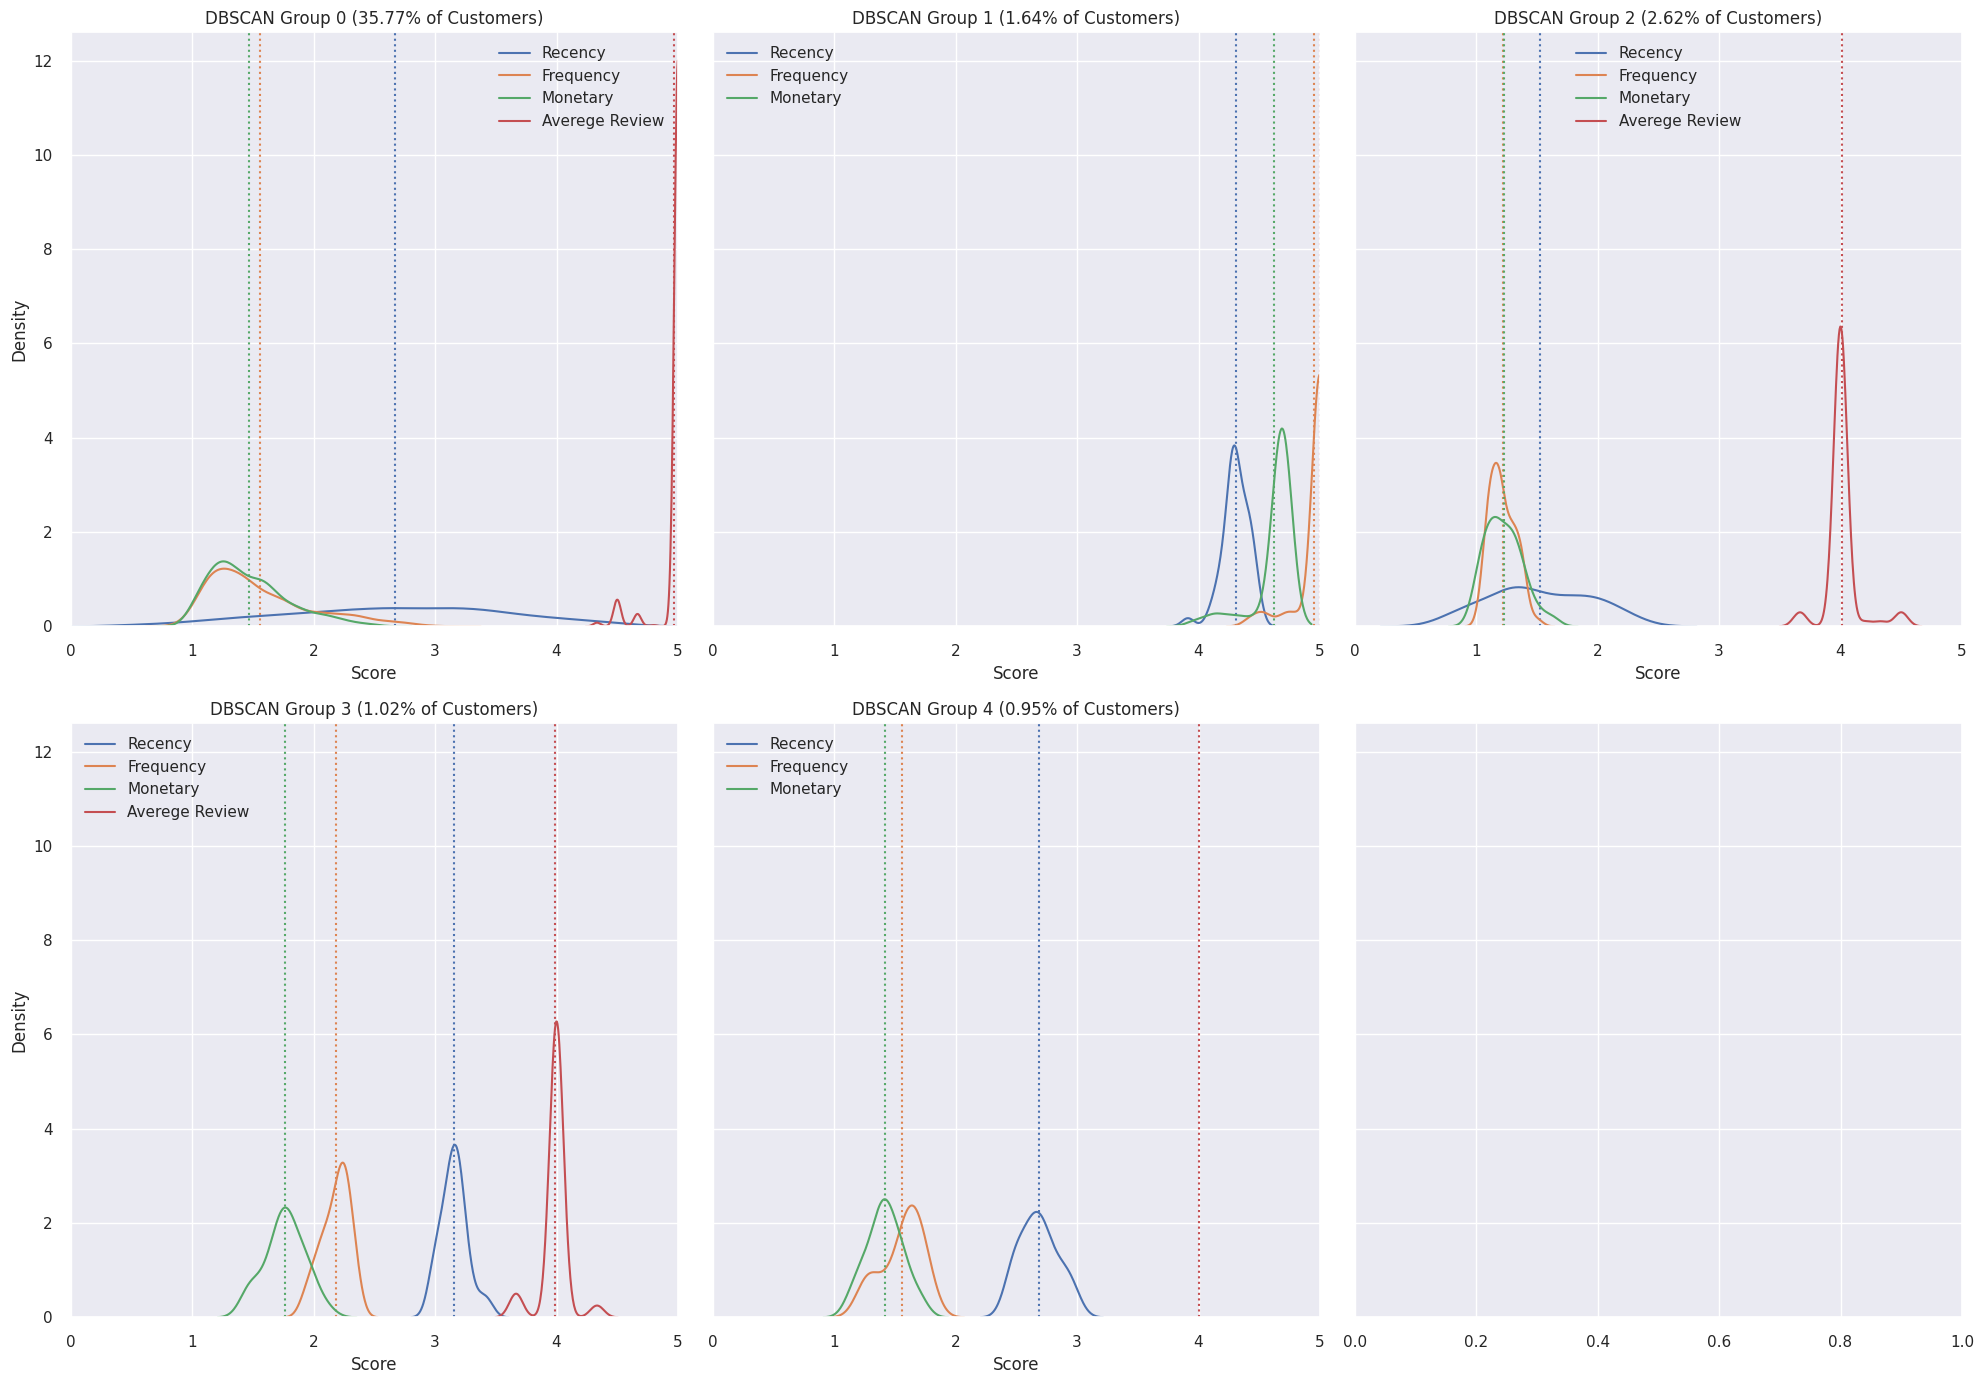

In [15]:
rfm_with_dbscan_group["dbscan_group"] = DBSCAN(eps=0.36, min_samples=25).fit_predict(
    rfm_with_dbscan_group[X_feats]
)
rfm_with_dbscan_group_wo_outliers = rfm_with_dbscan_group.loc[
    rfm_with_dbscan_group["dbscan_group"] != -1
]
ax_idx = 0
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True)
axs = axs.flatten()

fig.set_figwidth(20)
fig.set_figheight(14)

for group_label in sorted(
    rfm_with_dbscan_group_wo_outliers["dbscan_group"].unique().tolist()
):
    group_df = rfm_with_dbscan_group_wo_outliers.loc[
        rfm_with_dbscan_group_wo_outliers["dbscan_group"] == group_label
    ]

    sns.set(style="darkgrid")
    sns.kdeplot(
        data=group_df,
        x="recency_z_scaled",
        color=theme_clrs[0],
        label="Recency",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["recency_z_scaled"].mean(),
        color=theme_clrs[0],
        linestyle=":",
    )
    sns.kdeplot(
        data=group_df,
        x="frequency_z_scaled",
        color=theme_clrs[1],
        label="Frequency",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["frequency_z_scaled"].mean(),
        color=theme_clrs[1],
        linestyle=":",
    )
    sns.kdeplot(
        data=group_df,
        x="monetary_z_scaled",
        color=theme_clrs[2],
        label="Monetary",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["monetary_z_scaled"].mean(),
        color=theme_clrs[2],
        linestyle=":",
    )
    sns.kdeplot(
        data=group_df,
        x="avg_customer_review_score",
        color=theme_clrs[3],
        label="Averege Review",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["avg_customer_review_score"].mean(),
        color=theme_clrs[3],
        linestyle=":",
    )
    axs[ax_idx].set_xlim(left=0, right=5)
    axs[ax_idx].set_xlabel("Score")
    axs[ax_idx].set_title(
        "DBSCAN Group "
        + str(group_label)
        + f" ({round(group_df.shape[0] / rfm_with_dbscan_group.shape[0] * 100, 2)}% of Customers)"
    )

    axs[ax_idx].legend()

    ax_idx += 1

plt.tight_layout()
plt.show()


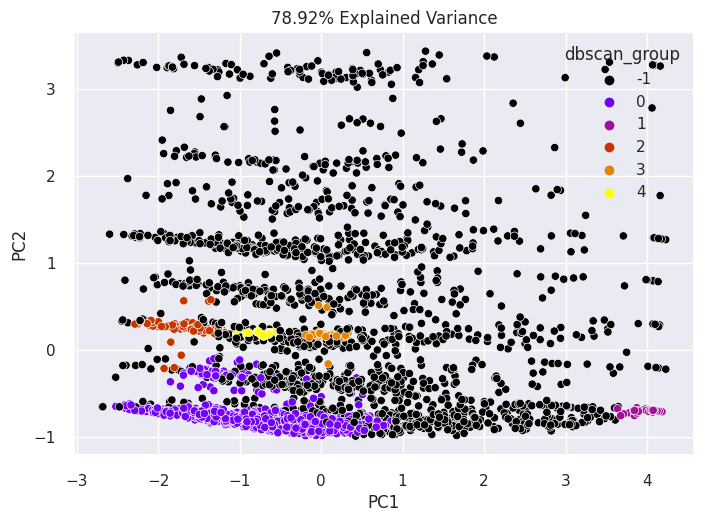

In [16]:
pca_dbscan = PCA(n_components=2)
rfm_dbscan_pca_df = pd.concat(
    [
        pd.DataFrame(
            pca_dbscan.fit_transform(rfm_with_dbscan_group[X_feats]),
            columns=["PC1", "PC2"],
        ),
        rfm_with_dbscan_group[["dbscan_group"]],
    ],
    axis=1,
)
exp_var_str = f"{round(sum(pca_dbscan.explained_variance_ratio_.tolist()) * 100, 2)}% Explained Variance"
pca_scatter = sns.scatterplot(
    rfm_dbscan_pca_df, x="PC1", y="PC2", hue="dbscan_group", palette="gnuplot"
)

plt.title(exp_var_str)
plt.show()


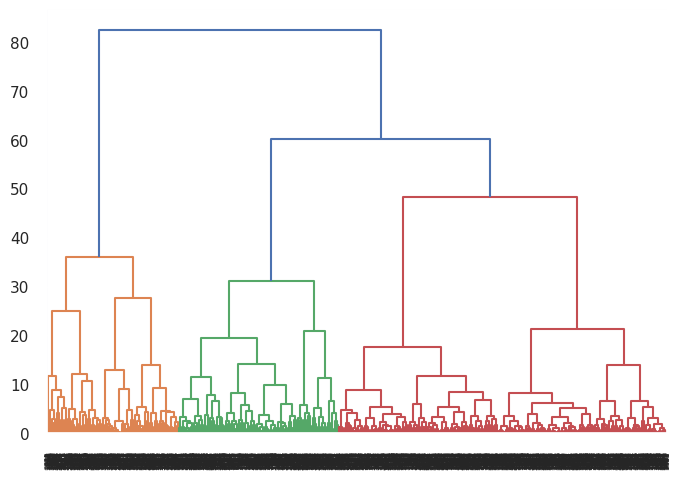

In [17]:
rfm_with_hac_group = rfm_normalized.copy()[X_feats].fillna(
    rfm_normalized["avg_customer_review_score"].mean()
)
dendrogram = sch.dendrogram(sch.linkage(rfm_with_hac_group, method="ward"))


In [18]:
hac_model = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")

hac_model.fit(rfm_with_hac_group)

rfm_with_hac_group["hac_group"] = hac_model.labels_

display(rfm_with_hac_group)

recency_z_scaled  frequency_z_scaled  monetary_z_scaled  \
0             2.328123            1.454149           2.436852   
1             2.999351            2.041552           1.216010   
2             3.981349            2.490797           2.427221   
3             3.634443            2.468339           1.481503   
4             1.460812            1.237065           1.821465   
...                ...                 ...                ...   
2740          3.693448            1.222283           1.336166   
2741          3.716079            1.910338           2.357830   
2742          3.005075            1.151271           1.086509   
2743          2.676678            1.735928           1.867204   
2744          2.137307            1.247952           1.177664   

      avg_customer_review_score  hac_group  
0                           5.0          0  
1                           5.0          3  
2                           4.0          2  
3                           4.0          2  
4                           5.0          1  
...                         ...        ...  
2740                        4.5          3  
2741                        2.0          2  
2742                        4.0          2  
2743                        1.0          2  
2744                        4.5          1  

[2745 rows x 5 columns]

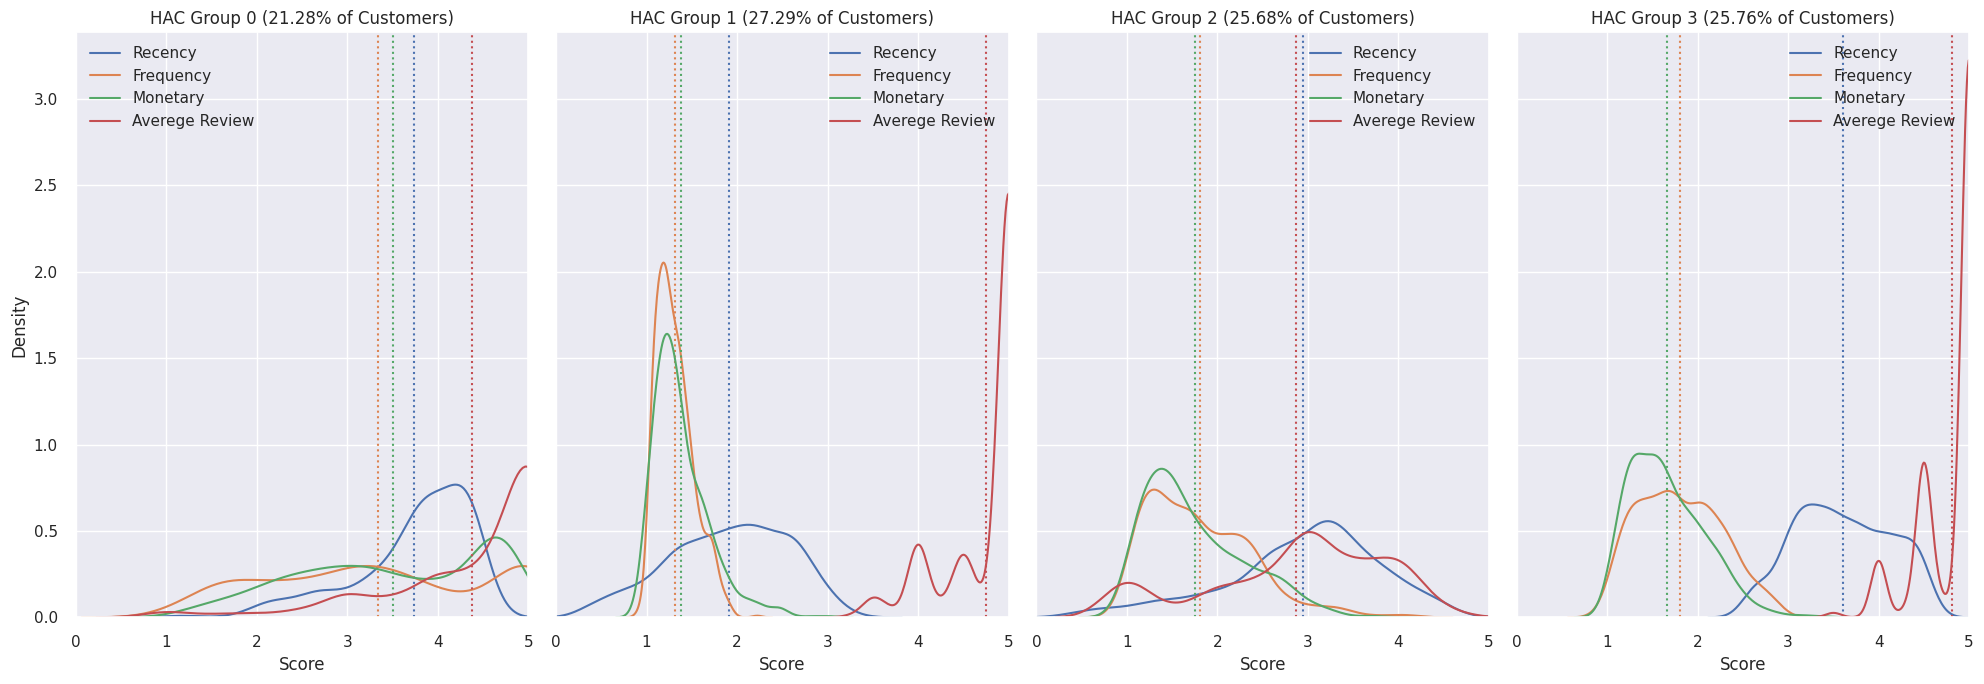

In [19]:
ax_idx = 0
fig, axs = plt.subplots(nrows=1, ncols=4, sharey=True)
axs = axs.flatten()

fig.set_figwidth(20)
fig.set_figheight(7)

for group_label in sorted(rfm_with_hac_group["hac_group"].unique().tolist()):
    group_df = rfm_with_hac_group.loc[rfm_with_hac_group["hac_group"] == group_label]

    sns.set(style="darkgrid")
    sns.kdeplot(
        data=group_df,
        x="recency_z_scaled",
        color=theme_clrs[0],
        label="Recency",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["recency_z_scaled"].mean(),
        color=theme_clrs[0],
        linestyle=":",
    )
    sns.kdeplot(
        data=group_df,
        x="frequency_z_scaled",
        color=theme_clrs[1],
        label="Frequency",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["frequency_z_scaled"].mean(),
        color=theme_clrs[1],
        linestyle=":",
    )
    sns.kdeplot(
        data=group_df,
        x="monetary_z_scaled",
        color=theme_clrs[2],
        label="Monetary",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["monetary_z_scaled"].mean(),
        color=theme_clrs[2],
        linestyle=":",
    )
    sns.kdeplot(
        data=group_df,
        x="avg_customer_review_score",
        color=theme_clrs[3],
        label="Averege Review",
        ax=axs[ax_idx],
        warn_singular=False,
    )
    axs[ax_idx].axvline(
        group_df["avg_customer_review_score"].mean(),
        color=theme_clrs[3],
        linestyle=":",
    )
    axs[ax_idx].set_xlim(left=0, right=5)
    axs[ax_idx].set_xlabel("Score")
    axs[ax_idx].set_title(
        "HAC Group "
        + str(group_label)
        + f" ({round(group_df.shape[0] / rfm_with_dbscan_group.shape[0] * 100, 2)}% of Customers)"
    )

    axs[ax_idx].legend()

    ax_idx += 1

plt.tight_layout()
plt.show()


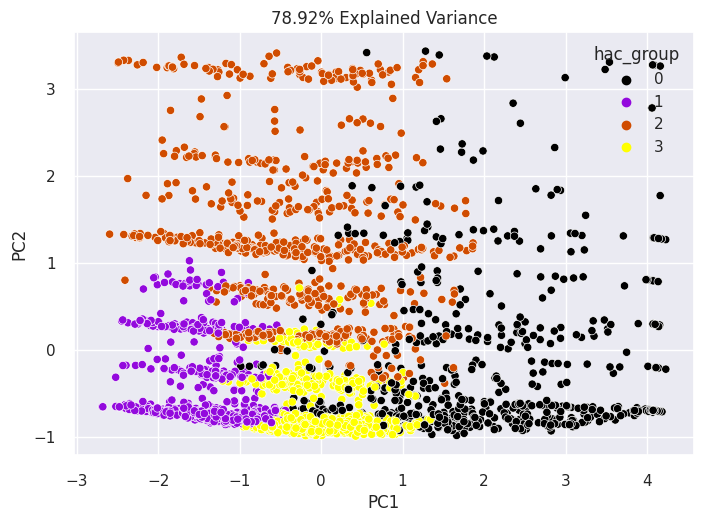

In [20]:
pca_hac = PCA(n_components=2)
rfm_hac_pca_df = pd.concat(
    [
        pd.DataFrame(
            pca_hac.fit_transform(rfm_with_hac_group[X_feats]),
            columns=["PC1", "PC2"],
        ),
        rfm_with_hac_group[["hac_group"]],
    ],
    axis=1,
)
exp_var_str = f"{round(sum(pca_hac.explained_variance_ratio_.tolist()) * 100, 2)}% Explained Variance"
pca_scatter = sns.scatterplot(
    rfm_hac_pca_df, x="PC1", y="PC2", hue="hac_group", palette="gnuplot"
)

plt.title(exp_var_str)
plt.show()


In [26]:
feats_to_norm = [
    "total_orders",
    "total_prods_ordered",
    "first_customer_review_score",
    "avg_customer_review_score",
    "total_spent",
    "order_delay_days",
    "months_since_last_purchase",
    "orders_per_month",
    "spent_per_month",
    "proport_orders_paid_in_install",
    "proport_orders_paid_lump_sum",
]
normed_feats = []
repeat_customers_w_norm_df = repeat_customers_df.copy()
repeat_customers_w_norm_df[
    ["first_customer_review_score"]
] = repeat_customers_w_norm_df[["first_customer_review_score"]].fillna(
    value=repeat_customers_w_norm_df["first_customer_review_score"].mean()
)
repeat_customers_w_norm_df[["avg_customer_review_score"]] = repeat_customers_w_norm_df[
    ["avg_customer_review_score"]
].fillna(value=repeat_customers_w_norm_df["avg_customer_review_score"].mean())

for feat in feats_to_norm:
    repeat_customers_w_norm_df[feat + "_norm"] = MinMaxScaler().fit_transform(
        repeat_customers_w_norm_df[feat].to_numpy().reshape(-1, 1)
    )

    normed_feats += [feat + "_norm"]

display(repeat_customers_w_norm_df)


customer_unique_id  total_orders  total_prods_ordered  \
0     4c93744516667ad3b8f1fb645a3116a4             2                    2   
1     1175e95fb47ddff9de6b2b06188f7e0d             2                    2   
2     295c05e81917928d76245e842748184d             2                    2   
3     e9dd12dca17352644a959d9dea133935             2                    2   
4     e079b18794454de9d2be5c12b4392294             2                    6   
...                                ...           ...                  ...   
2796  574e36a816bf7a295404e686062fc0de             2                    3   
2797  76f7d40948174f5cde0fcf8e6147b59d             2                    4   
2798  88fcb680dc8cd2e540010c0750b78242             2                    2   
2799  2dcbfb99d95c7ba6eb992a98627f45b8             2                    3   
2800  da29b8a3970adddb9ed2dc8a492065af             2                    2   

      first_customer_review_score  avg_customer_review_score reordered  \
0                             5.0                        5.0      True   
1                             5.0                        5.0      True   
2                             3.0                        4.0      True   
3                             3.0                        4.0      True   
4                             5.0                        5.0      True   
...                           ...                        ...       ...   
2796                          4.0                        4.5      True   
2797                          2.0                        2.0      True   
2798                          4.0                        4.0      True   
2799                          1.0                        1.0      True   
2800                          4.0                        4.5      True   

     high_first_rating                                          order_ids  \
0                 True  [5741ea1f91b5fbab2bd2dc653a5b5099, 98b737f8bd0...   
1                 True  [7845a2492ab1b4f2cf3d56c7b8da1446, 1ebeea841c5...   
2                False  [cf5e115a19c54f0457aa4c00fb88ae63, 852d2f4d377...   
3                False  [19c0c76962278b152cc44fc63ffd5e48, f916cacb752...   
4                 True  [77b062be7c5bd21712905feb8e1cfeed, 7e3fefb35b0...   
...                ...                                                ...   
2796              True  [25c0762610a416a21571e4ab3cf179b8, 325c8590cc2...   
2797             False  [09d49d145e25e27490765a4085a8e720, b95ee76467f...   
2798              True  [eda613a4e8989dac08362e3326431eaa, 00772b2af35...   
2799             False  [ce5f998d724ed1ac61c890e33b24a33f, 4035b52134b...   
2800              True  [614c5cb06a982f6034ec63bb29030868, 56a69975037...   

                              order_purchase_timestamps  total_spent  ...  \
0     [2017-10-15T12:44:13.000000, 2017-09-14T18:14:...       565.88  ...   
1     [2018-01-18T12:35:45.000000, 2018-01-18T12:35:...        83.19  ...   
2     [2018-06-06T11:59:53.000000, 2018-03-07T15:57:...       281.50  ...   
3     [2018-04-18T09:42:53.000000, 2018-03-05T18:12:...       113.83  ...   
4     [2017-06-14T18:52:29.000000, 2017-06-14T18:31:...       437.78  ...   
...                                                 ...          ...  ...   
2796  [2018-04-26T18:07:40.000000, 2017-06-06T17:00:...       222.86  ...   
2797  [2018-04-29T22:59:41.000000, 2017-12-30T00:06:...       373.60  ...   
2798  [2018-01-19T08:02:06.000000, 2017-04-24T10:53:...       118.61  ...   
2799  [2017-12-03T20:37:09.000000, 2017-11-28T01:16:...       285.23  ...   
2800  [2017-09-18T12:37:24.000000, 2017-06-20T12:40:...       145.42  ...   

      total_prods_ordered_norm  first_customer_review_score_norm  \
0                     0.000000                              1.00   
1                     0.000000                              1.00   
2                     0.000000                              0.50   
3                     0.000000                              0.50   
4               

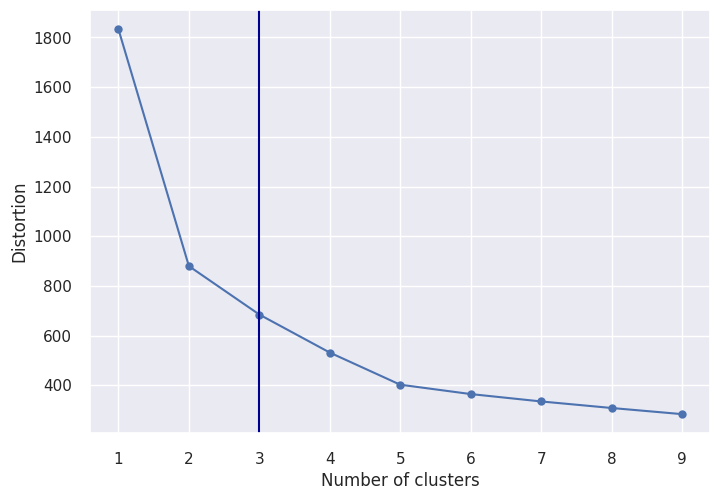

In [27]:
distortions = []

for i in range(1, 10):
    k_means_model = KMeans(n_clusters=i, n_init=10, random_state=0)

    k_means_model.fit(repeat_customers_w_norm_df[normed_feats])
    distortions.append(k_means_model.inertia_)

num_clusters = KneeLocator(range(1, 10), distortions, curve="convex", direction="decreasing").elbow

plt.plot(range(1, 10), distortions, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.axvline(num_clusters)
sns.set_style("darkgrid")
sns.set_palette("gnuplot2")
plt.show()

In [28]:
repeat_customers_w_norm_df["k_means_cluster"] = KMeans(
    n_clusters=num_clusters, n_init=10, random_state=0
).fit_predict(repeat_customers_w_norm_df[normed_feats])

display(repeat_customers_w_norm_df)

customer_unique_id  total_orders  total_prods_ordered  \
0     4c93744516667ad3b8f1fb645a3116a4             2                    2   
1     1175e95fb47ddff9de6b2b06188f7e0d             2                    2   
2     295c05e81917928d76245e842748184d             2                    2   
3     e9dd12dca17352644a959d9dea133935             2                    2   
4     e079b18794454de9d2be5c12b4392294             2                    6   
...                                ...           ...                  ...   
2796  574e36a816bf7a295404e686062fc0de             2                    3   
2797  76f7d40948174f5cde0fcf8e6147b59d             2                    4   
2798  88fcb680dc8cd2e540010c0750b78242             2                    2   
2799  2dcbfb99d95c7ba6eb992a98627f45b8             2                    3   
2800  da29b8a3970adddb9ed2dc8a492065af             2                    2   

      first_customer_review_score  avg_customer_review_score reordered  \
0                             5.0                        5.0      True   
1                             5.0                        5.0      True   
2                             3.0                        4.0      True   
3                             3.0                        4.0      True   
4                             5.0                        5.0      True   
...                           ...                        ...       ...   
2796                          4.0                        4.5      True   
2797                          2.0                        2.0      True   
2798                          4.0                        4.0      True   
2799                          1.0                        1.0      True   
2800                          4.0                        4.5      True   

     high_first_rating                                          order_ids  \
0                 True  [5741ea1f91b5fbab2bd2dc653a5b5099, 98b737f8bd0...   
1                 True  [7845a2492ab1b4f2cf3d56c7b8da1446, 1ebeea841c5...   
2                False  [cf5e115a19c54f0457aa4c00fb88ae63, 852d2f4d377...   
3                False  [19c0c76962278b152cc44fc63ffd5e48, f916cacb752...   
4                 True  [77b062be7c5bd21712905feb8e1cfeed, 7e3fefb35b0...   
...                ...                                                ...   
2796              True  [25c0762610a416a21571e4ab3cf179b8, 325c8590cc2...   
2797             False  [09d49d145e25e27490765a4085a8e720, b95ee76467f...   
2798              True  [eda613a4e8989dac08362e3326431eaa, 00772b2af35...   
2799             False  [ce5f998d724ed1ac61c890e33b24a33f, 4035b52134b...   
2800              True  [614c5cb06a982f6034ec63bb29030868, 56a69975037...   

                              order_purchase_timestamps  total_spent  ...  \
0     [2017-10-15T12:44:13.000000, 2017-09-14T18:14:...       565.88  ...   
1     [2018-01-18T12:35:45.000000, 2018-01-18T12:35:...        83.19  ...   
2     [2018-06-06T11:59:53.000000, 2018-03-07T15:57:...       281.50  ...   
3     [2018-04-18T09:42:53.000000, 2018-03-05T18:12:...       113.83  ...   
4     [2017-06-14T18:52:29.000000, 2017-06-14T18:31:...       437.78  ...   
...                                                 ...          ...  ...   
2796  [2018-04-26T18:07:40.000000, 2017-06-06T17:00:...       222.86  ...   
2797  [2018-04-29T22:59:41.000000, 2017-12-30T00:06:...       373.60  ...   
2798  [2018-01-19T08:02:06.000000, 2017-04-24T10:53:...       118.61  ...   
2799  [2017-12-03T20:37:09.000000, 2017-11-28T01:16:...       285.23  ...   
2800  [2017-09-18T12:37:24.000000, 2017-06-20T12:40:...       145.42  ...   

      first_customer_review_score_norm  avg_customer_review_score_norm  \
0                                 1.00                           1.000   
1                                 1.00                           1.000   
2                                 0.50                           0.750   
3                                 0.50                      

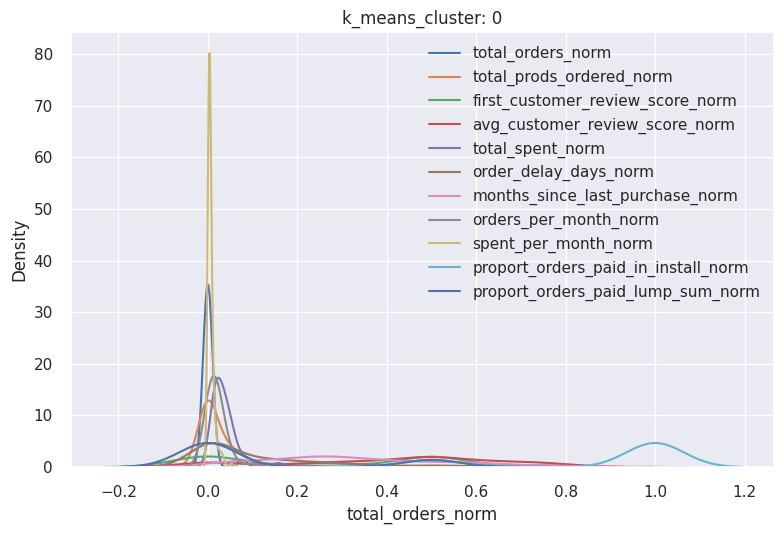

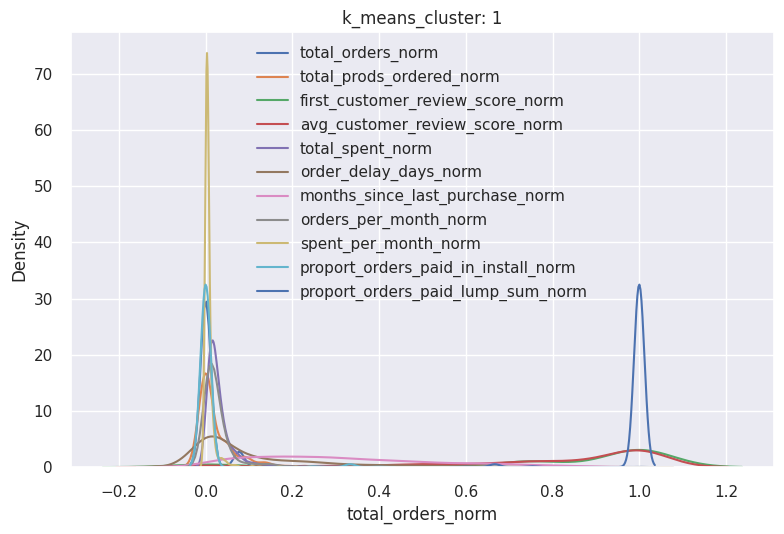

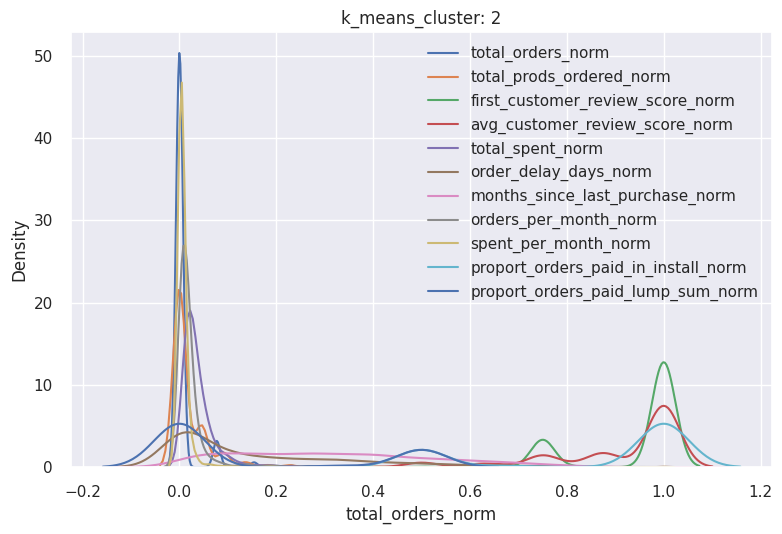

In [37]:
# ax_idx = 0
# fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True)
# axs = axs.flatten()

# fig.set_figwidth(20)
# fig.set_figheight(7)

for group_label in sorted(
    repeat_customers_w_norm_df["k_means_cluster"].unique().tolist()
):
    group_df = repeat_customers_w_norm_df.loc[
        repeat_customers_w_norm_df["k_means_cluster"] == group_label
    ]

    sns.set(style="darkgrid")

    for feat in normed_feats:
        sns.kdeplot(
            data=group_df,
            x=feat,
            label=feat,
            # ax=axs[ax_idx],
            warn_singular=False,
        )
        
    # axs[ax_idx].legend()

    # ax_idx += 1
    plt.title(f"k_means_cluster: {group_label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# plt.tight_layout()
# plt.show()

In [ ]:
repeat_customers_w_norm_df.to_feather("repeat_customers_w_norm_df.ftr")